# Project for People's Daily - Part #[3]

## Network Analysis

In [1]:
import dask
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import jieba
import re
import string
from zhon.hanzi import punctuation, stops, non_stops
import gensim
from gensim.models.word2vec import Word2Vec, LineSentence
import linecache
import timeit
import warnings
import zipfile
import os
import sys
warnings.filterwarnings('ignore')

## Corpus Loading

In [2]:
news_df_sort=pd.read_csv('final_corpus_rmrb.csv')

In [3]:
news_df_sort

Unnamed: 0  year  month        date issue column  \
0          64375  1965      1  1965-01-03     2    NaN   
1          64388  1965      1  1965-01-03     3    NaN   
2          64446  1965      1  1965-01-05     2     社论   
3          64573  1965      1  1965-01-08     4    NaN   
4          64584  1965      1  1965-01-09     2     短评   
...          ...   ...    ...         ...   ...    ...   
9686      560917  2002     12  2002-12-18  1_要闻    NaN   
9687      560968  2002     12  2002-12-19  2_要闻    NaN   
9688      561196  2002     12  2002-12-24  1_要闻    NaN   
9689      561277  2002     12  2002-12-26  1_要闻    NaN   
9690      561407  2002     12  2002-12-29  1_要闻    NaN   

                                             date_title  \
0                               1965-01-03坚决破除迷信 改进原有设计   
1                            1965-01-03用新的斗争和新的成就迎接新的一年   
2     1965-01-05革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会...   
3           1965-01-08美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运   
4                                      1965-01-09创造力的解放   
...                                                 ...   
9686            2002-12-18李鹏在福建考察时指出人大要为发展民主政治建设政治文明作贡献   
9687                  2002-12-19社区深处党旗红——福州市鼓楼区社区党建工作调查   
9688           2002-12-24人大常委会第三十一次会议举行 李鹏主持全体会议并参加分组审议   
9689               2002-12-26外出闯世界找到致富路长春：劳务输出成为农民增收增长点   
9690        2002-12-29人大常委会第三十一次会议闭幕李鹏主持并讲话表决通过民办教育促进法等   

                                           title author  \
0                                  坚决破除迷信 改进原有设计    NaN   
1                               用新的斗争和新的成就迎接新的一年    NaN   
2     革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会议的伟大成就    NaN   
3              美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运    NaN   
4                                         创造力的解放    NaN   
...                                          ...    ...   
9686               李鹏在福建考察时指出人大要为发展民主政治建设政治文明作贡献  傅旭蔡小伟   
9687                     社区深处党旗红——福州市鼓楼区社区党建工作调查  蔡小伟赵鹏   
9688              人大常委会第三十一次会议举行 李鹏主持全体会议并参加分组审议  傅旭石国胜   
9689                  外出闯世界找到致富路长春：劳务输出成为农民增收增长点  李忠春江山   
9690           人大常委会第三十一次会议闭幕李鹏主持并讲话表决通过民办教育促进法等  傅旭石国胜   

                                                   text  \
0     坚决破除迷信　改进原有设计洛阳轴承厂在严格的科学精神指导下，开展群众性的技术革新活动，轴承品...   
1     用新的斗争和新的成就迎接新的一年金日成首相号召朝鲜人民努力完成七年计划和加强反修斗争艾地主席...   
2     革命的大会　民主的大会　团结的大会第三届全国人民代表大会第一次会议胜利闭幕了。会议听取了周恩...   
3     朝越坦等国舆论抨击约翰逊国情咨文以和平词藻掩饰侵略野心美帝陷入各国人民四面八方包围之中  约...   
4     卢王庄公社第一年种水稻，就得到了好收成。这件事情又一次雄辩地说明：社会主义革命是社会主义生产...   
...                                                 ...   
9686  本报福州12月17日电记者傅旭、蔡小伟报道：全国人大常委会委员长李鹏近日在福建就全国人大常委...   
9687  今年50多岁的老党员刘用镇，4年前从外地搬到福州市鼓楼区福屿社区开了一家饮食店。生意红火，收...   
9688  本报北京12月23日讯记者傅旭、石国胜报道：九届全国人大常委会第三十一次会议今天上午举行全体...   
9689  本报长春12月25日电记者李忠春、江山报道：吉林省长春市把农民增收作为农村工作的主要目标，引...   
9690  本报北京十二月二十八日讯记者傅旭、石国胜报道：九届全国人大常委会第三十一次会议于今天上午闭幕...   

                                         tokenized_sent  \
0     [['坚决', '破除迷信', '改进', '原有', '设计'], ['洛阳', '轴承厂...   
1     [['斗争', '成就', '迎接', '一年', '金日成', '首相', '号召', '...   
2     [['革命', '大会', '民主', '大会', '团结', '大会'], ['第三届',...   
3     [['朝越', '坦等国', '舆论', '抨击', '约翰逊', '国情咨文', '和平'...   
4     [['卢王庄', '公社', '第一年', '水稻', '得到', '好收成'], ['这件...   
...                                                 ...   
9686  [['本报', '福州', '12', '17', '日电', '记者', '傅旭', '蔡...   
9687  [['今年', '50', '多岁', '党员', '刘用', '年前', '外地', '福...   
9688  [['本报', '北京', '12', '23', '日讯', '记者', '傅旭', '石...   
9689  [['本报', '长春', '12', '25', '日电', '记者', '李忠春', '...   
9690  [['本报', '北京', '十二月', '二十八日', '记者', '傅旭', '石国胜'...   

                                             token_para  
0     ['坚决 破除迷信 改进 原有 设计', '洛阳 轴承厂 严格 科学 精神 指导 开展 群众...  
1     ['斗争 成就 迎接 一年 金日成 首相 号召 朝鲜 人民 努力完成 七年 计划 加强 反修...  
2     ['革命 大会 民主 大会 团结 大会', '第三届 全国人民代表大会 第一次 会议 胜利 ...  
3     ['朝越 坦等国 舆论 抨击 约翰逊 国情咨文 和平 词藻 掩饰 侵略 野心', '美帝 陷...  
4     ['卢王庄 公社 第一年 水稻 得到 好收成', '这件 事情 一次 雄辩 说明 社会主义 ...  
...                                                 ...  
9686  ['本报 福州 12 17 日电 记者 傅旭 蔡小伟 报道 全国人大常委会 委员长 李鹏 近...  
9687  ['今

In [4]:
news_df_sort=news_df_sort.drop(['Unnamed: 0'], axis=1)

In [5]:
corpus=news_df_sort.copy()

In [6]:
tokenized_sent_str=news_df_sort['tokenized_sent'].values

In [7]:
token_sent_clean=[]
for doc in tokenized_sent_str:
    #print(doc)
    token_sent_clean.append([[y.strip().strip(string.punctuation) for y in x.split(',') if len(y)>0] 
                             for x in doc.lstrip('[').rstrip(']').split(']') if len(x)>0])

In [8]:
corpus=corpus.drop(['tokenized_sent'],axis=1)
corpus.insert(10, 'tokenized_sent',token_sent_clean,True)

In [9]:
tokenized_para_str=news_df_sort['token_para'].values

In [10]:
token_para_clean=[]
for doc in tokenized_para_str:
    #print(doc)
    token_para_clean.append([x.strip().strip("'") 
                             for x in doc.lstrip('[').rstrip(']').split(',') if len(x)>0])

In [11]:
corpus=corpus.drop(['token_para'],axis=1)
corpus.insert(9, 'token_para',token_para_clean,True)

In [12]:
news_df_sort.head()

year  month        date issue column  \
0  1965      1  1965-01-03     2    NaN   
1  1965      1  1965-01-03     3    NaN   
2  1965      1  1965-01-05     2     社论   
3  1965      1  1965-01-08     4    NaN   
4  1965      1  1965-01-09     2     短评   

                                          date_title  \
0                            1965-01-03坚决破除迷信 改进原有设计   
1                         1965-01-03用新的斗争和新的成就迎接新的一年   
2  1965-01-05革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会...   
3        1965-01-08美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运   
4                                   1965-01-09创造力的解放   

                                        title author  \
0                               坚决破除迷信 改进原有设计    NaN   
1                            用新的斗争和新的成就迎接新的一年    NaN   
2  革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会议的伟大成就    NaN   
3           美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运    NaN   
4                                      创造力的解放    NaN   

                                                text  \
0  坚决破除迷信　改进原有设计洛阳轴承厂在严格的科学精神指导下，开展群众性的技术革新活动，轴承品...   
1  用新的斗争和新的成就迎接新的一年金日成首相号召朝鲜人民努力完成七年计划和加强反修斗争艾地主席...   
2  革命的大会　民主的大会　团结的大会第三届全国人民代表大会第一次会议胜利闭幕了。会议听取了周恩...   
3  朝越坦等国舆论抨击约翰逊国情咨文以和平词藻掩饰侵略野心美帝陷入各国人民四面八方包围之中  约...   
4  卢王庄公社第一年种水稻，就得到了好收成。这件事情又一次雄辩地说明：社会主义革命是社会主义生产...   

                                      tokenized_sent  \
0  [['坚决', '破除迷信', '改进', '原有', '设计'], ['洛阳', '轴承厂...   
1  [['斗争', '成就', '迎接', '一年', '金日成', '首相', '号召', '...   
2  [['革命', '大会', '民主', '大会', '团结', '大会'], ['第三届',...   
3  [['朝越', '坦等国', '舆论', '抨击', '约翰逊', '国情咨文', '和平'...   
4  [['卢王庄', '公社', '第一年', '水稻', '得到', '好收成'], ['这件...   

                                          token_para  
0  ['坚决 破除迷信 改进 原有 设计', '洛阳 轴承厂 严格 科学 精神 指导 开展 群众...  
1  ['斗争 成就 迎接 一年 金日成 首相 号召 朝鲜 人民 努力完成 七年 计划 加强 反修...  
2  ['革命 大会 民主 大会 团结 大会', '第三届 全国人民代表大会 第一次 会议 胜利 ...  
3  ['朝越 坦等国 舆论 抨击 约翰逊 国情咨文 和平 词藻 掩饰 侵略 野心', '美帝 陷...  
4  ['卢王庄 公社 第一年 水稻 得到 好收成', '这件 事情 一次 雄辩 说明 社会主义 ...

In [13]:
corpus.head()

year  month        date issue column  \
0  1965      1  1965-01-03     2    NaN   
1  1965      1  1965-01-03     3    NaN   
2  1965      1  1965-01-05     2     社论   
3  1965      1  1965-01-08     4    NaN   
4  1965      1  1965-01-09     2     短评   

                                          date_title  \
0                            1965-01-03坚决破除迷信 改进原有设计   
1                         1965-01-03用新的斗争和新的成就迎接新的一年   
2  1965-01-05革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会...   
3        1965-01-08美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运   
4                                   1965-01-09创造力的解放   

                                        title author  \
0                               坚决破除迷信 改进原有设计    NaN   
1                            用新的斗争和新的成就迎接新的一年    NaN   
2  革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会议的伟大成就    NaN   
3           美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运    NaN   
4                                      创造力的解放    NaN   

                                                text  \
0  坚决破除迷信　改进原有设计洛阳轴承厂在严格的科学精神指导下，开展群众性的技术革新活动，轴承品...   
1  用新的斗争和新的成就迎接新的一年金日成首相号召朝鲜人民努力完成七年计划和加强反修斗争艾地主席...   
2  革命的大会　民主的大会　团结的大会第三届全国人民代表大会第一次会议胜利闭幕了。会议听取了周恩...   
3  朝越坦等国舆论抨击约翰逊国情咨文以和平词藻掩饰侵略野心美帝陷入各国人民四面八方包围之中  约...   
4  卢王庄公社第一年种水稻，就得到了好收成。这件事情又一次雄辩地说明：社会主义革命是社会主义生产...   

                                          token_para  \
0  [坚决 破除迷信 改进 原有 设计, 洛阳 轴承厂 严格 科学 精神 指导 开展 群众性 技...   
1  [斗争 成就 迎接 一年 金日成 首相 号召 朝鲜 人民 努力完成 七年 计划 加强 反修 ...   
2  [革命 大会 民主 大会 团结 大会, 第三届 全国人民代表大会 第一次 会议 胜利 闭幕,...   
3  [朝越 坦等国 舆论 抨击 约翰逊 国情咨文 和平 词藻 掩饰 侵略 野心, 美帝 陷入 各...   
4  [卢王庄 公社 第一年 水稻 得到 好收成, 这件 事情 一次 雄辩 说明 社会主义 革命 ...   

                                      tokenized_sent  
0  [[坚决, 破除迷信, 改进, 原有, 设计], [洛阳, 轴承厂, 严格, 科学, 精神,...  
1  [[斗争, 成就, 迎接, 一年, 金日成, 首相, 号召, 朝鲜, 人民, 努力完成, 七...  
2  [[革命, 大会, 民主, 大会, 团结, 大会], [第三届, 全国人民代表大会, 第一次...  
3  [[朝越, 坦等国, 舆论, 抨击, 约翰逊, 国情咨文, 和平, 词藻, 掩饰, 侵略, ...  
4  [[卢王庄, 公社, 第一年, 水稻, 得到, 好收成], [这件, 事情, 一次, 雄辩,...

# network analysis

In [14]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import string

In [15]:
year_mask1=range(1965,1978)
year_mask2=range(1978,1985)
year_mask3=range(1985,1993)
year_mask4=range(1993,2003)

corpus_65,corpus_75,corpus_85,corpus_95=corpus[:0],corpus[:0],corpus[:0],corpus[:0]

for year in year_mask1:
    corpus_65=corpus_65.append(corpus[corpus['year']==year])

for year in year_mask2:
    corpus_75=corpus_75.append(corpus[corpus['year']==year])
    
for year in year_mask3:
    corpus_85=corpus_85.append(corpus[corpus['year']==year])
    
for year in year_mask4:
    corpus_95=corpus_95.append(corpus[corpus['year']==year])

In [16]:
len(corpus_65)+len(corpus_75)+len(corpus_85)+len(corpus_95)

9691

### year node network visualization

In [18]:
# create the year based corpus
# sampling due to the heavy computing in later on network construct

year_corpus_dict={'year':[],'token_str':[]}

for year in range(1965,2003):
    temp=corpus[corpus['year']==year]
    year_corpus_dict['year'].append(year)
    
    token_str=[]
    for lis in temp['tokenized_sent']:
        
        temps=' '.join([y for x in lis for y in x][::100])
        token_str.append(temps)
        
    year_corpus_dict['token_str'].append(' '.join(token_str))

In [19]:
year_corpus=pd.DataFrame(year_corpus_dict)

In [20]:
year_corpus.head()

year                                          token_str
0  1965  坚决 设计 床头 机床 清洗机 轴承 考验 斗争 朝鲜 印度尼西亚 行动 人民 遭到 革命 ...
1  1966  一九六六年 交通运输业 高涨 实行 运动 毛泽东思想 一切 大寨 几年 祖国 积极 还有 摆...
2  1967  无产阶级 学校 浩浩荡荡 可以 爱憎分明 革命 扫除 天津市 积极 作成 金猴 这些 伟大领...
3  1968  伟大领袖 毛主席 说生 引导 清真 斗争 指向 作风 贫下中农 打击 毛主席 方向 纵深 中...
4  1969  湖北省 问题 教导 毛泽东思想 学习班 邀请 青海 委员 各项 广大群众 宣传 调查 最明 ...

In [21]:
len(year_corpus)

38

In [22]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [23]:
%%time

rmVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer=tokenize)
rmVects_incidence = rmVectorizer.fit_transform(year_corpus['token_str'])

CPU times: user 715 ms, sys: 5.8 ms, total: 721 ms
Wall time: 720 ms


In [24]:
rmVects_incidence.shape

(38, 14763)

In [25]:
%%time

g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((rmVectorizer.get_feature_names()[i] for i in range(rmVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(rmVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, rmVectorizer.get_feature_names()[w], {'weight' : rmVects_incidence[d, w]}) for d, w in zip(*rmVects_incidence.nonzero())))

CPU times: user 6min 55s, sys: 1.68 s, total: 6min 57s
Wall time: 6min 57s


In [26]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 14801
Number of edges: 46303
Average degree:   6.2567


In [27]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [28]:
gDoc = contractNetwork(g_2mode, 'doc')

In [29]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 703
Average degree:  37.0000


In [30]:
gDoc.remove_nodes_from(list(nx.isolates(gDoc)))

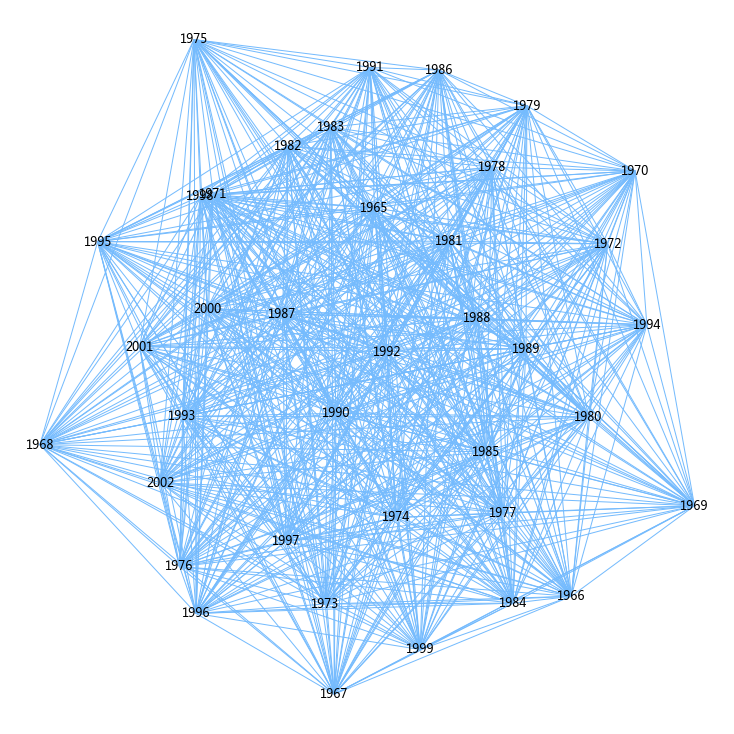

In [57]:
plt.figure(figsize=(10,10))

layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n+1965 for n in gDoc.nodes()},
        node_size = 0,
        node_color = "xkcd:light grey",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

### word cooccurence in sent

In [79]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [80]:
%%time

# 65-77

g65 = wordCooccurrence(corpus_65['tokenized_sent'].sum())

CPU times: user 3min 5s, sys: 1min 4s, total: 4min 10s
Wall time: 4min 33s


In [81]:
len(g65)

58980

In [82]:
%%time

g65_2=g65.copy()

g65_2.remove_edges_from([(n1, n2) for n1, n2, d in g65_2.edges(data = True) if d['weight'] <= 300])
g65_2.remove_nodes_from(list(nx.isolates(g65_2))) #since we are changing the graph list() evaluates the isolates first
len(g65_2)

CPU times: user 27.3 s, sys: 387 ms, total: 27.7 s
Wall time: 27.7 s


517

In [83]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [84]:
giant65 = max(connected_component_subgraphs(g65_2), key=len) # keep just the giant connected component
print(nx.info(giant65))

Name: 
Type: Graph
Number of nodes: 503
Number of edges: 3127
Average degree:  12.4334


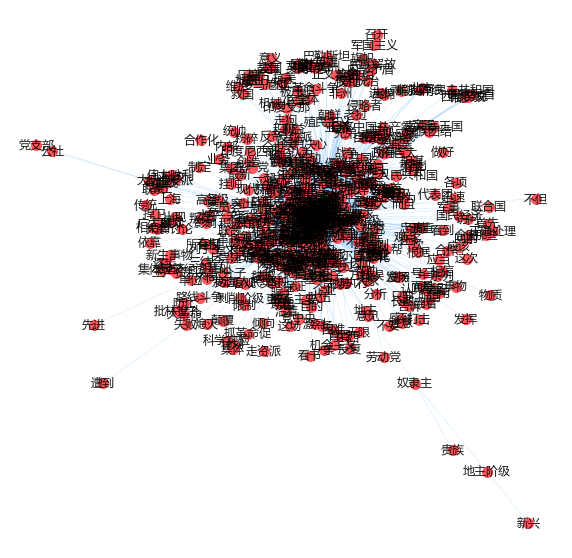

In [85]:
layout = nx.spring_layout(giant65, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant65, ax = ax, pos = layout, labels = {n:n for n in giant65.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [86]:
%%time

# 78-84

g75 = wordCooccurrence(corpus_75['tokenized_sent'].sum())

CPU times: user 2min 34s, sys: 56.6 s, total: 3min 31s
Wall time: 3min 51s


In [87]:
%%time

g75_2=g75.copy()

g75_2.remove_edges_from([(n1, n2) for n1, n2, d in g75_2.edges(data = True) if d['weight'] <= 700])
g75_2.remove_nodes_from(list(nx.isolates(g75_2))) #since we are changing the graph list() evaluates the isolates first
len(g75_2)

CPU times: user 24.2 s, sys: 328 ms, total: 24.5 s
Wall time: 24.5 s


117

In [88]:
giant75 = max(connected_component_subgraphs(g75_2), key=len) # keep just the giant connected component
print(nx.info(giant75))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 279
Average degree:   5.7526


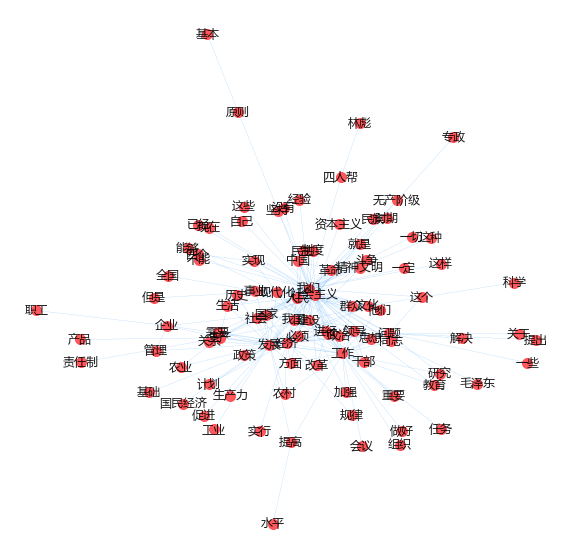

In [89]:
layout = nx.spring_layout(giant75, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant75, ax = ax, pos = layout, labels = {n:n for n in giant75.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [90]:
%%time

# 85-92

g85 = wordCooccurrence(corpus_85['tokenized_sent'].sum())

CPU times: user 4min 9s, sys: 1min 38s, total: 5min 47s
Wall time: 6min 27s


In [91]:
%%time

g85_2=g85.copy()

g85_2.remove_edges_from([(n1, n2) for n1, n2, d in g85_2.edges(data = True) if d['weight'] <= 1200])
g85_2.remove_nodes_from(list(nx.isolates(g85_2))) #since we are changing the graph list() evaluates the isolates first
len(g85_2)

CPU times: user 33.1 s, sys: 593 ms, total: 33.7 s
Wall time: 33.8 s


59

In [92]:
giant85 = max(connected_component_subgraphs(g85_2), key=len) # keep just the giant connected component
print(nx.info(giant85))

Name: 
Type: Graph
Number of nodes: 53
Number of edges: 129
Average degree:   4.8679


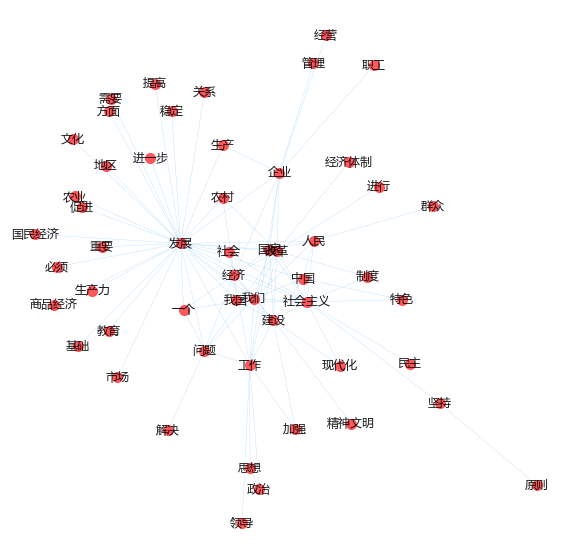

In [93]:
layout = nx.spring_layout(giant85, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant85, ax = ax, pos = layout, labels = {n:n for n in giant85.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [94]:
%%time

# 93-02

g95 = wordCooccurrence(corpus_95['tokenized_sent'].sum())

CPU times: user 5min 43s, sys: 3min 6s, total: 8min 50s
Wall time: 11min 4s


In [95]:
%%time

g95_2=g95.copy()

g95_2.remove_edges_from([(n1, n2) for n1, n2, d in g95_2.edges(data = True) if d['weight'] <= 1000])
g95_2.remove_nodes_from(list(nx.isolates(g95_2))) #since we are changing the graph list() evaluates the isolates first
len(g95_2)

CPU times: user 38.4 s, sys: 933 ms, total: 39.4 s
Wall time: 39.6 s


127

In [96]:
giant95 = max(connected_component_subgraphs(g95_2), key=len) # keep just the giant connected component
print(nx.info(giant95))

Name: 
Type: Graph
Number of nodes: 110
Number of edges: 356
Average degree:   6.4727


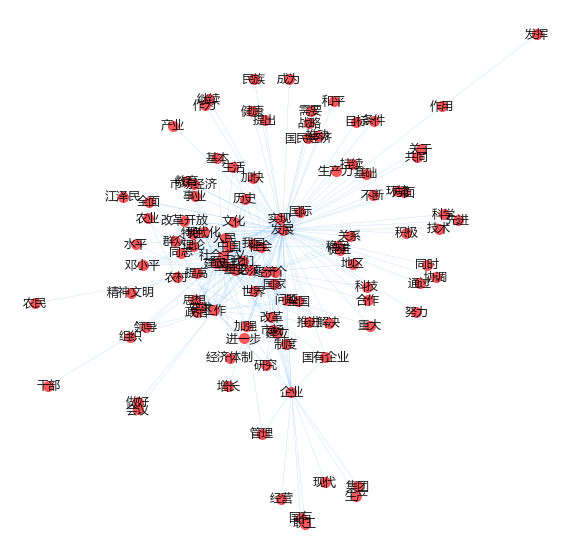

In [97]:
layout = nx.spring_layout(giant95, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant95, ax = ax, pos = layout, labels = {n:n for n in giant95.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [98]:
### neighbors of economy

In [99]:
s65Neighbors = giant65.neighbors('经济')
g_s65 = giant65.subgraph(s65Neighbors)
print(nx.info(g_s65))

Name: 
Type: Graph
Number of nodes: 26
Number of edges: 302
Average degree:  23.2308


In [100]:
# translate to english

from googletrans import Translator
translator = Translator()

In [101]:
gs65_dict={}

for n in g_s65.nodes():
    print(n,translator.translate(n,dest='en').text)
    gs65_dict[n]=translator.translate(n,dest='en').text

文化 culture
政策 policy
社会主义 socialism
毛主席 Chairman mao
他们 they
方面 aspect
建设 Construction
革命 revolution
经济 economic
国家 country
一个 One
问题 problem
资产阶级 Bourgeois
我们 we
进行 get on
发展 development of
关系 relationship
无产阶级 proletariat
人民 people
社会 society
我国 Country
生产 produce
政治 political
工作 jobs
斗争 struggle
资本主义 Capitalism


In [102]:
# modify some translations

gs65_dict['我国']='our country'
gs65_dict['发展']='development'
gs65_dict['毛主席']='Chairman Mao'

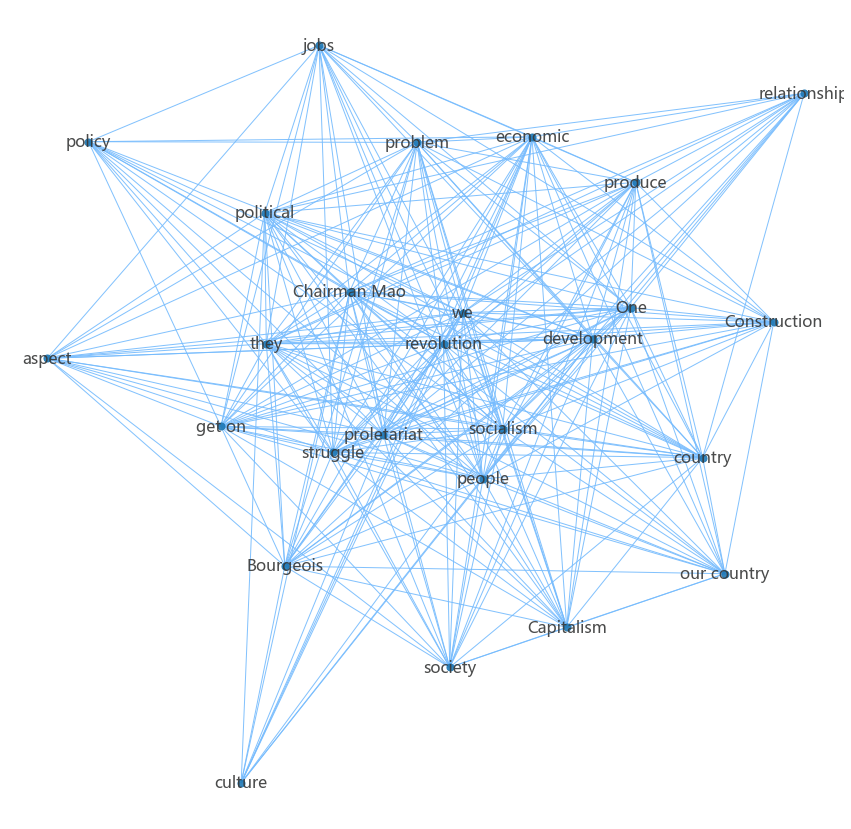

In [103]:
layout_amer = nx.spring_layout(g_s65, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,15))
maxWeight = max((d['weight'] for n1, n2, d in g_s65.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_s65.edges(data = True)))
nx.draw(g_s65, ax = ax, pos = layout_amer, labels = {n:gs65_dict[n] for n in g_s65.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_s1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        node_size=50,
        cmap = plt.get_cmap('plasma')) 

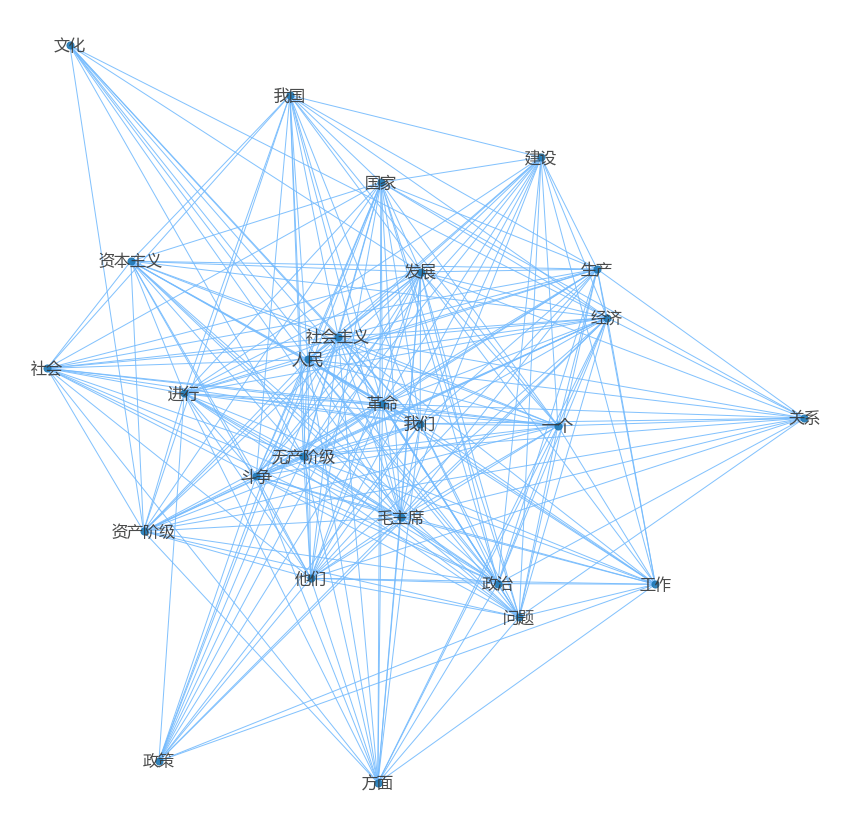

In [104]:
# chinese figure

layout_amer = nx.spring_layout(g_s65, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,15))
maxWeight = max((d['weight'] for n1, n2, d in g_s65.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_s65.edges(data = True)))
nx.draw(g_s65, ax = ax, pos = layout_amer, labels = {n:n for n in g_s65.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_s1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        node_size=50,
        cmap = plt.get_cmap('plasma')) 

In [105]:
s75Neighbors = giant75.neighbors('经济')
g_s75 = giant75.subgraph(s75Neighbors)
print(nx.info(g_s75))

Name: 
Type: Graph
Number of nodes: 27
Number of edges: 129
Average degree:   9.5556


In [106]:
gs75_dict={}

for n in g_s75.nodes():
    print(n,translator.translate(n,dest='en').text)
    gs75_dict[n]=translator.translate(n,dest='en').text

文化 culture
政策 policy
社会主义 socialism
方面 aspect
建设 Construction
企业 enterprise
经济 economic
农村 Countryside
国家 country
一个 One
需要 need
问题 problem
实行 Implement
计划 plan
规律 law
进行 get on
发展 development of
改革 reform
人民 people
社会 society
我国 Country
生产 produce
政治 political
必须 have to
工作 jobs
管理 management
我们 we


In [107]:
# modify some translations

gs75_dict['我国']='our country'
gs75_dict['发展']='development'

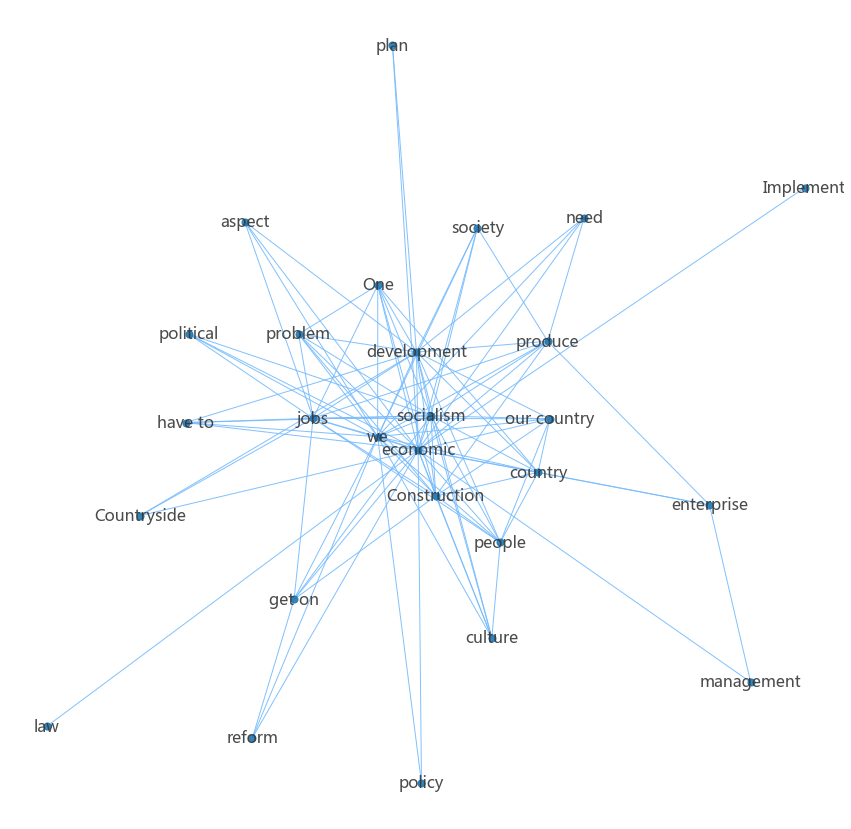

In [108]:
layout_amer = nx.spring_layout(g_s75, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,15))
maxWeight = max((d['weight'] for n1, n2, d in g_s75.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_s75.edges(data = True)))
nx.draw(g_s75, ax = ax, pos = layout_amer, labels = {n:gs75_dict[n] for n in g_s75.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_s1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        node_size=50,
        cmap = plt.get_cmap('plasma')) 

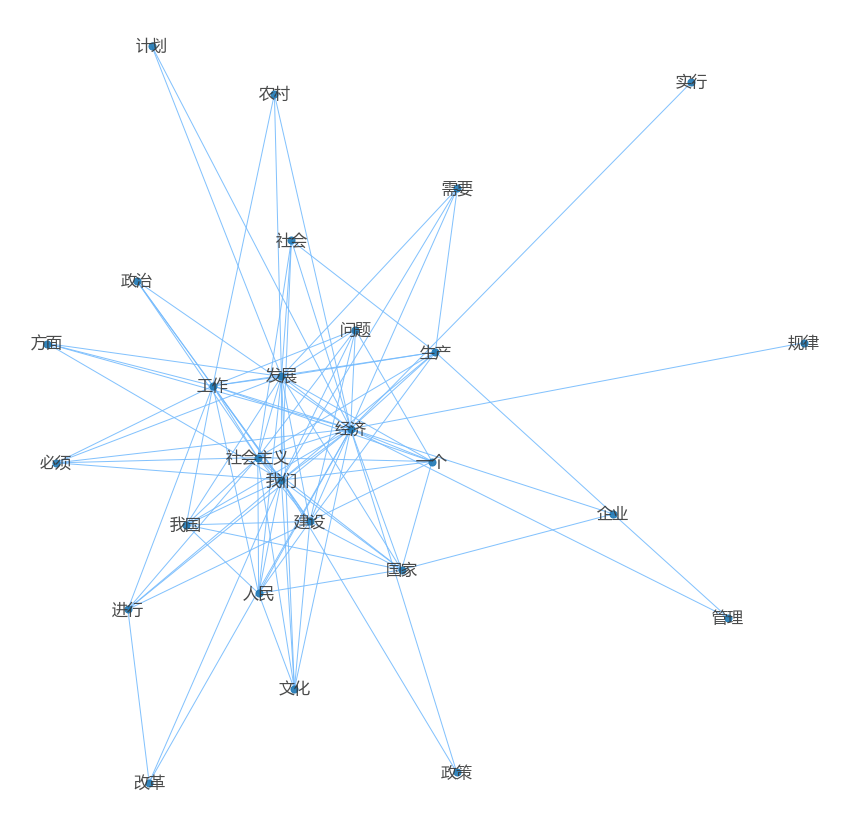

In [109]:
#chinese

layout_amer = nx.spring_layout(g_s75, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,15))
maxWeight = max((d['weight'] for n1, n2, d in g_s75.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_s75.edges(data = True)))
nx.draw(g_s75, ax = ax, pos = layout_amer, labels = {n:n for n in g_s75.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_s1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        node_size=50,
        cmap = plt.get_cmap('plasma')) 

In [110]:
s85Neighbors = giant85.neighbors('经济')
g_s85 = giant85.subgraph(s85Neighbors)
print(nx.info(g_s85))

Name: 
Type: Graph
Number of nodes: 14
Number of edges: 63
Average degree:   9.0000


In [111]:
gs85_dict={}

for n in g_s85.nodes():
    print(n,translator.translate(n,dest='en').text)
    gs85_dict[n]=translator.translate(n,dest='en').text

我国 Country
发展 development of
企业 enterprise
改革 reform
经济 economic
社会主义 socialism
农村 Countryside
国家 country
一个 One
工作 jobs
问题 problem
社会 society
我们 we
建设 Construction


In [112]:
# modify some translations

gs85_dict['我国']='our country'
gs85_dict['发展']='development'

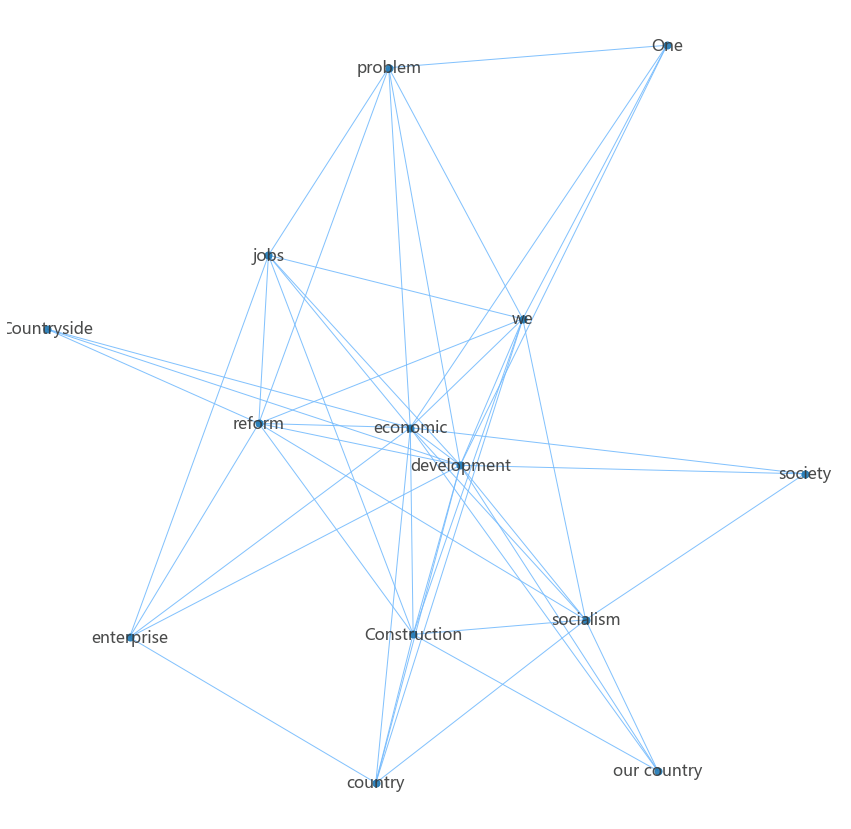

In [113]:
layout_amer = nx.spring_layout(g_s85, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,15))
maxWeight = max((d['weight'] for n1, n2, d in g_s85.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_s85.edges(data = True)))
nx.draw(g_s85, ax = ax, pos = layout_amer, labels = {n:gs85_dict[n] for n in g_s85.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_s1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        node_size=50,
        cmap = plt.get_cmap('plasma')) 

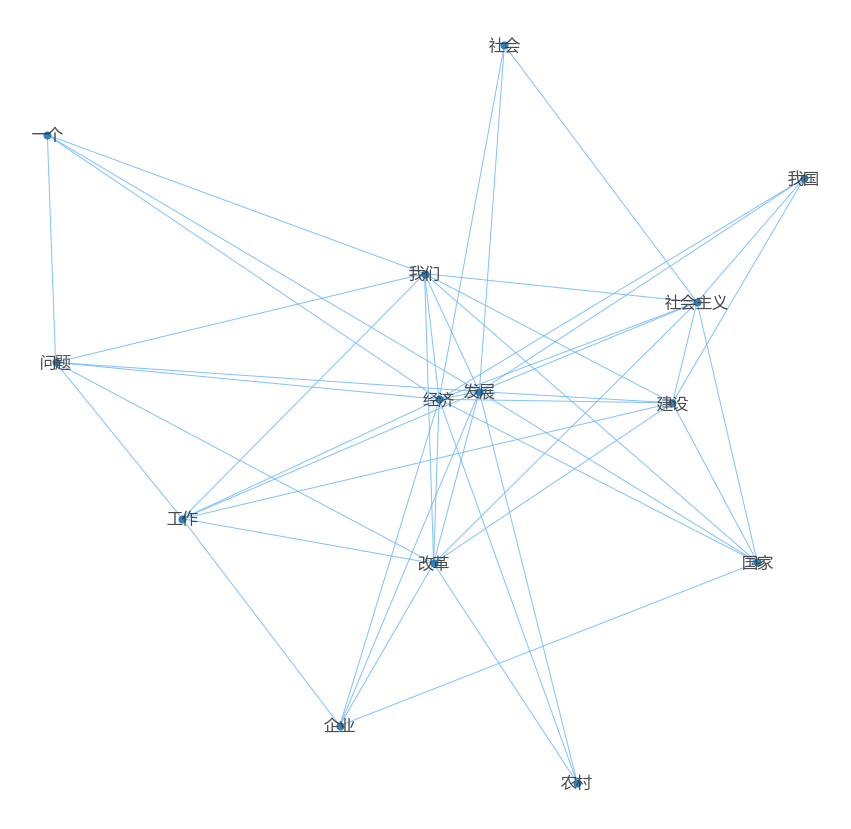

In [114]:
# chinese 

layout_amer = nx.spring_layout(g_s85, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,15))
maxWeight = max((d['weight'] for n1, n2, d in g_s85.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_s85.edges(data = True)))
nx.draw(g_s85, ax = ax, pos = layout_amer, labels = {n:n for n in g_s85.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_s1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        node_size=50,
        cmap = plt.get_cmap('plasma')) 

In [115]:
s95Neighbors = giant95.neighbors('经济')
g_s95 = giant95.subgraph(s95Neighbors)
print(nx.info(g_s95))

Name: 
Type: Graph
Number of nodes: 34
Number of edges: 181
Average degree:  10.6471


In [116]:
gs95_dict={}

for n in g_s95.nodes():
    print(n,translator.translate(n,dest='en').text)
    gs95_dict[n]=translator.translate(n,dest='en').text

社会主义 socialism
加强 strengthen
中国 China
建设 Construction
企业 enterprise
经济 economic
合作 Cooperation
农村 Countryside
国家 country
提高 improve
一个 One
问题 problem
地区 area
稳定 stable
坚持 adhere to
发展 development of
加快 accelerate
关系 relationship
改革 reform
人民 people
社会 society
科技 Science and Technology
重要 important
我国 Country
实现 achieve
政治 political
国际 International
促进 promote
世界 world
必须 have to
工作 jobs
市场 market
增长 increase
我们 we


In [117]:
# modify some translations

gs95_dict['我国']='our country'
gs95_dict['发展']='development'

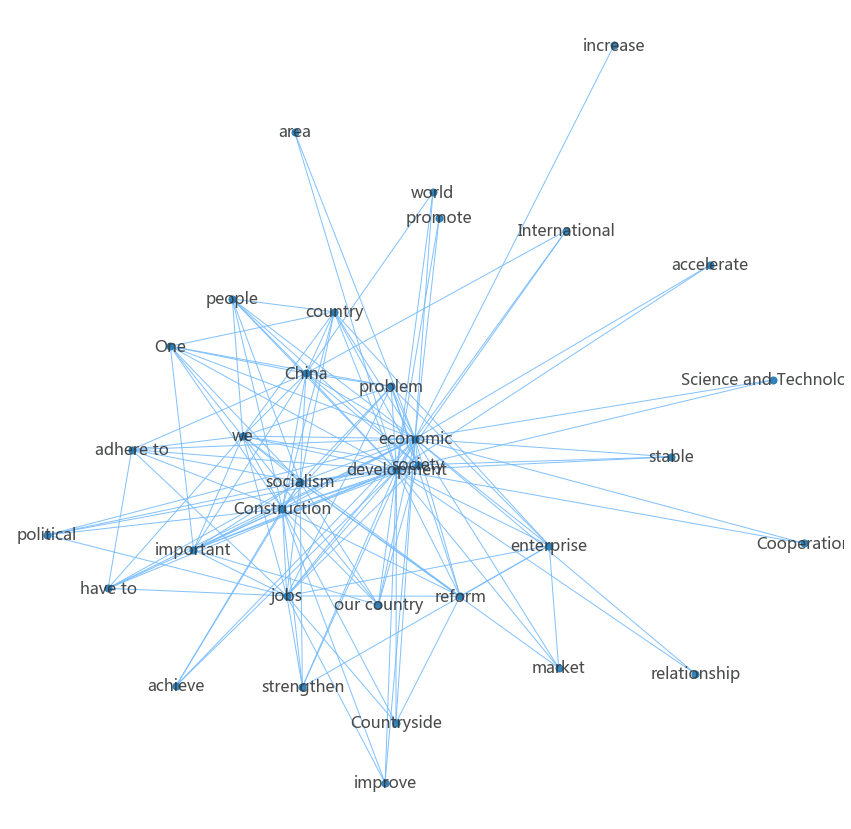

In [118]:
layout_amer = nx.spring_layout(g_s95, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,15))
maxWeight = max((d['weight'] for n1, n2, d in g_s95.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_s95.edges(data = True)))
nx.draw(g_s95, ax = ax, pos = layout_amer, labels = {n:gs95_dict[n] for n in g_s95.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_s1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        node_size=50,
        cmap = plt.get_cmap('plasma')) 

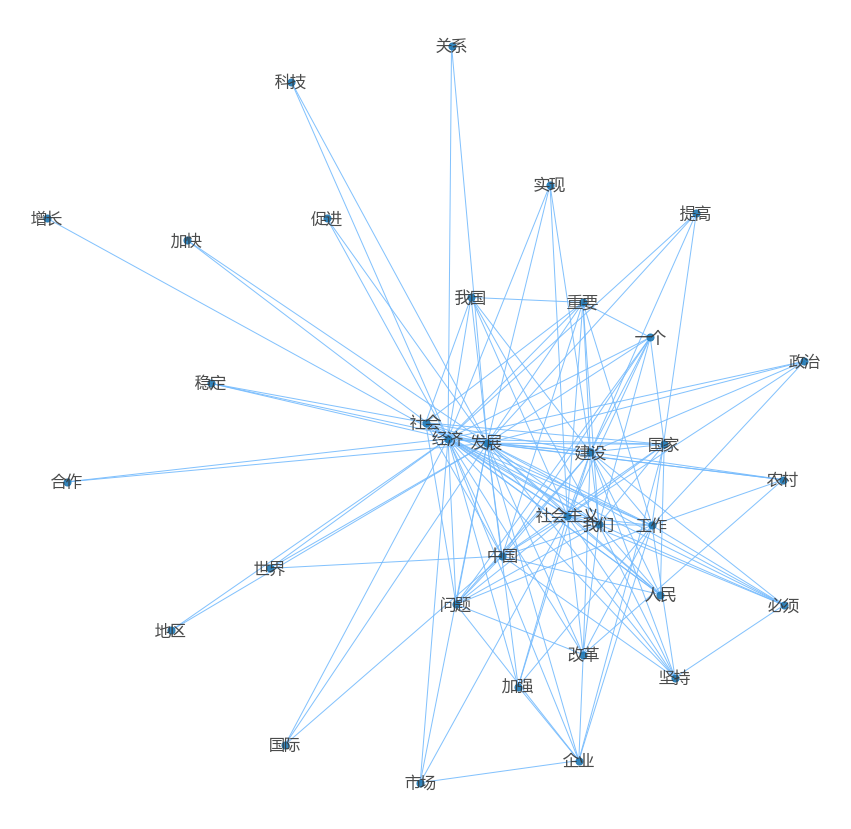

In [119]:
# chinese

layout_amer = nx.spring_layout(g_s95, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (15,15))
maxWeight = max((d['weight'] for n1, n2, d in g_s95.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_s95.edges(data = True)))
nx.draw(g_s95, ax = ax, pos = layout_amer, labels = {n:n for n in g_s95.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_s1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        node_size=50,
        cmap = plt.get_cmap('plasma')) 

## network stats 

In [88]:
dcentralities65 = nx.degree_centrality(giant65)

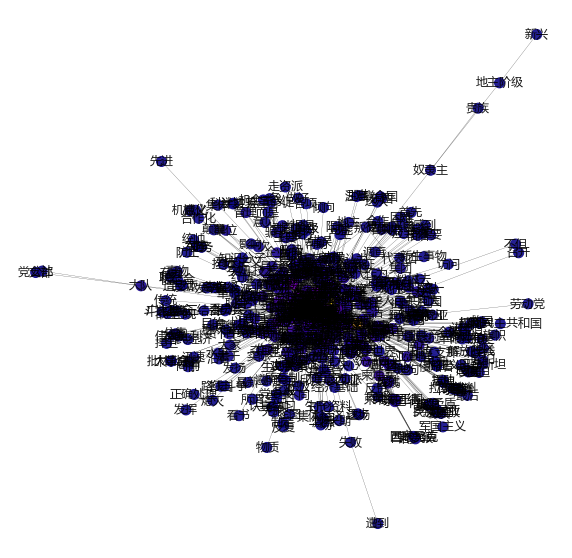

In [89]:
layout = nx.spring_layout(giant65, weight='weight', iterations= 100)

fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities65.items(), key = lambda x : x[1])[1]
nx.draw(giant65, ax = ax, pos = layout, labels = {n:n for n in giant65.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities65[n] / maxC for n in giant65.nodes],
        cmap = plt.get_cmap('plasma')) 

In [90]:
sorted(dcentralities65.items(), key = lambda x: x[1], reverse = True)[:10]

[('革命', 0.5956175298804781),
 ('我们', 0.5438247011952191),
 ('人民', 0.5),
 ('社会主义', 0.3705179282868526),
 ('无产阶级', 0.35856573705179284),
 ('毛主席', 0.3286852589641434),
 ('斗争', 0.30677290836653387),
 ('他们', 0.2549800796812749),
 ('发展', 0.23306772908366533),
 ('资产阶级', 0.17330677290836652)]

In [91]:
dcentralities75 = nx.degree_centrality(giant75)

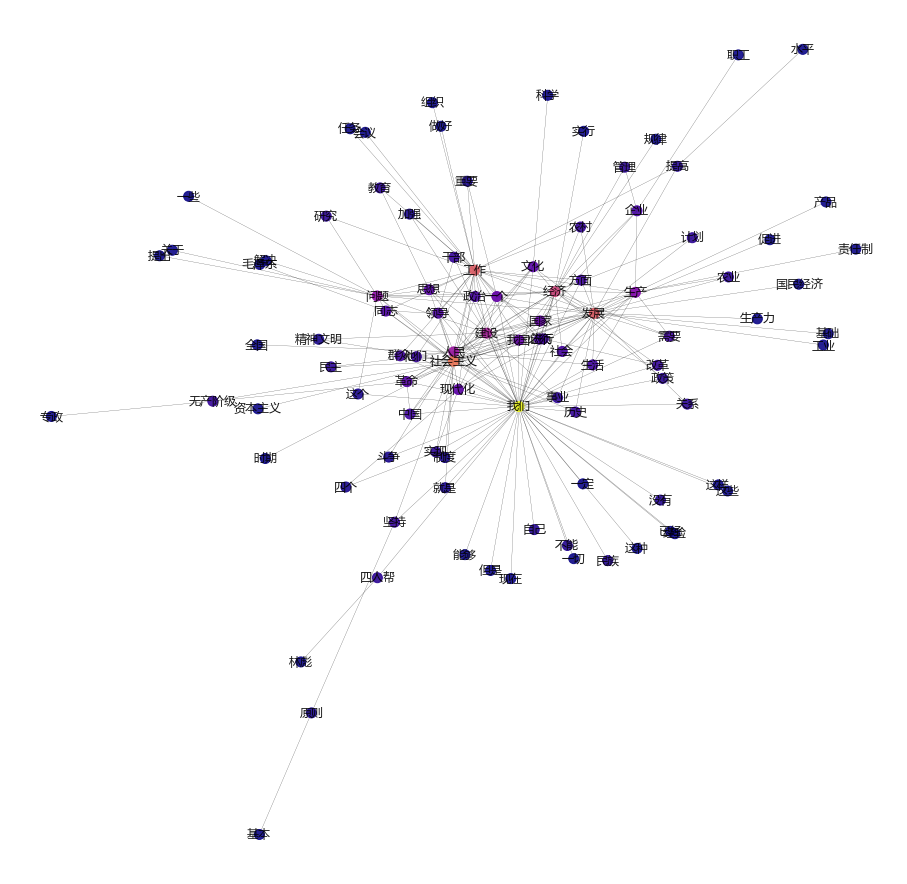

In [92]:
layout = nx.spring_layout(giant75, weight='weight', iterations= 100)

fig, ax = plt.subplots(figsize = (16,16))
maxC = max(dcentralities75.items(), key = lambda x : x[1])[1]
nx.draw(giant75, ax = ax, pos = layout, labels = {n:n for n in giant75.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities75[n] / maxC for n in giant75.nodes],
        cmap = plt.get_cmap('plasma')) 

In [93]:
sorted(dcentralities75.items(), key = lambda x: x[1], reverse = True)[:10]

[('我们', 0.5833333333333333),
 ('社会主义', 0.38541666666666663),
 ('发展', 0.34375),
 ('工作', 0.34375),
 ('经济', 0.29166666666666663),
 ('建设', 0.21875),
 ('人民', 0.19791666666666666),
 ('问题', 0.17708333333333331),
 ('生产', 0.15625),
 ('一个', 0.11458333333333333)]

In [94]:
dcentralities85 = nx.degree_centrality(giant85)

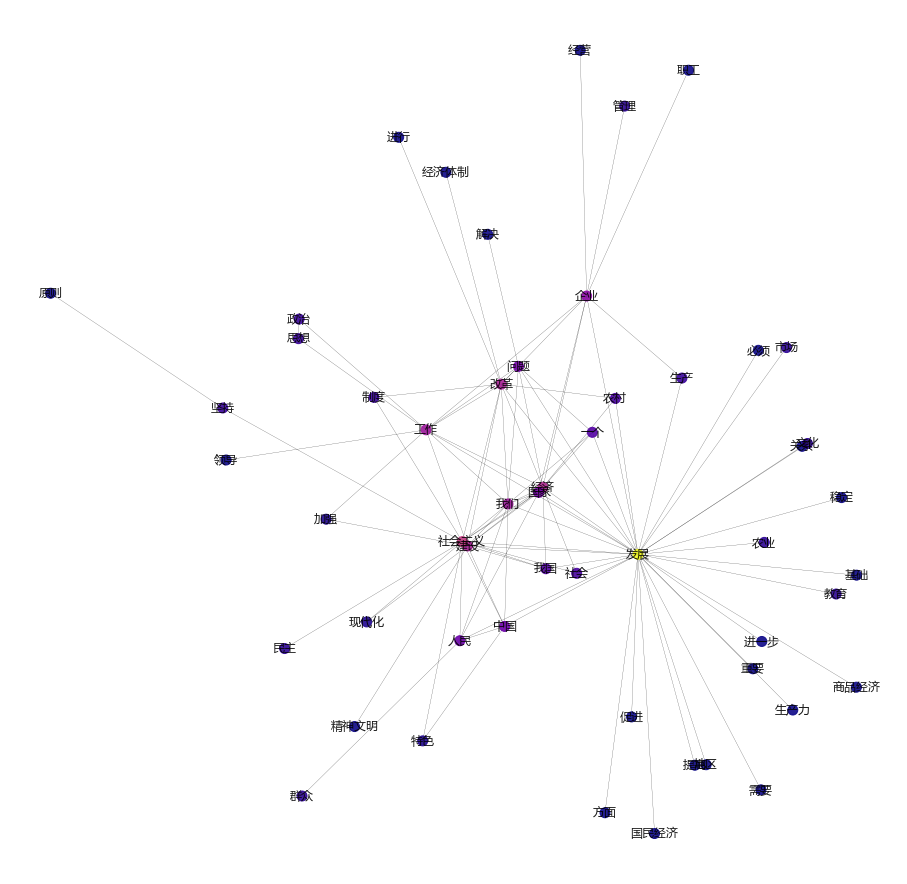

In [95]:
layout = nx.spring_layout(giant85, weight='weight', iterations= 100)

fig, ax = plt.subplots(figsize = (16,16))
maxC = max(dcentralities85.items(), key = lambda x : x[1])[1]
nx.draw(giant85, ax = ax, pos = layout, labels = {n:n for n in giant85.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities85[n] / maxC for n in giant85.nodes],
        cmap = plt.get_cmap('plasma')) 

In [96]:
sorted(dcentralities85.items(), key = lambda x: x[1], reverse = True)[:10]

[('发展', 0.6923076923076923),
 ('社会主义', 0.3269230769230769),
 ('经济', 0.2884615384615385),
 ('改革', 0.2692307692307693),
 ('建设', 0.2692307692307693),
 ('我们', 0.25),
 ('工作', 0.25),
 ('企业', 0.21153846153846156),
 ('国家', 0.17307692307692307),
 ('问题', 0.17307692307692307)]

In [97]:
dcentralities95 = nx.degree_centrality(giant95)

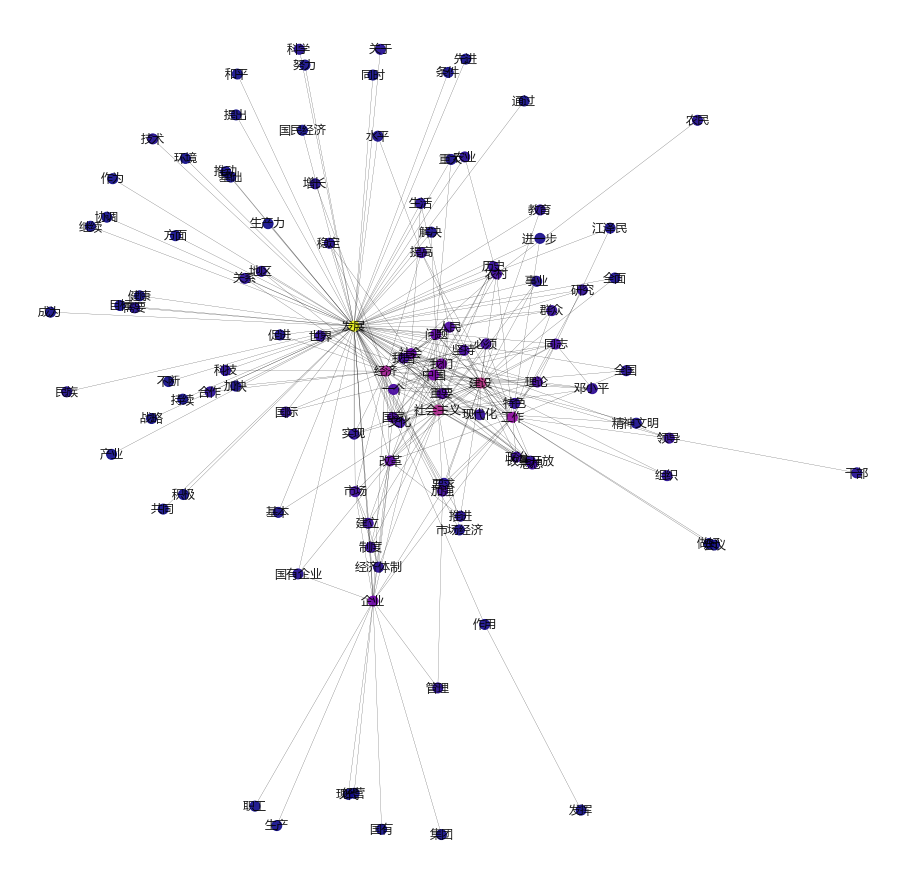

In [98]:
layout = nx.spring_layout(giant95, weight='weight', iterations= 100)

fig, ax = plt.subplots(figsize = (16,16))
maxC = max(dcentralities95.items(), key = lambda x : x[1])[1]
nx.draw(giant95, ax = ax, pos = layout, labels = {n:n for n in giant95.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities95[n] / maxC for n in giant95.nodes],
        cmap = plt.get_cmap('plasma')) 

In [99]:
sorted(dcentralities95.items(), key = lambda x: x[1], reverse = True)[:10]

[('发展', 0.8623853211009175),
 ('建设', 0.3761467889908257),
 ('社会主义', 0.3486238532110092),
 ('经济', 0.3211009174311927),
 ('工作', 0.26605504587155965),
 ('中国', 0.21100917431192662),
 ('我们', 0.1926605504587156),
 ('企业', 0.1834862385321101),
 ('社会', 0.1559633027522936),
 ('改革', 0.14678899082568808)]

In [28]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [101]:
# 65-77

giant_filtered3065 = filterWords(giant65, minWeight=3, filter_='eigenvector', rule='number', value_of_rule=25)
print(nx.info(giant_filtered3065))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 313
Average degree:  25.0400


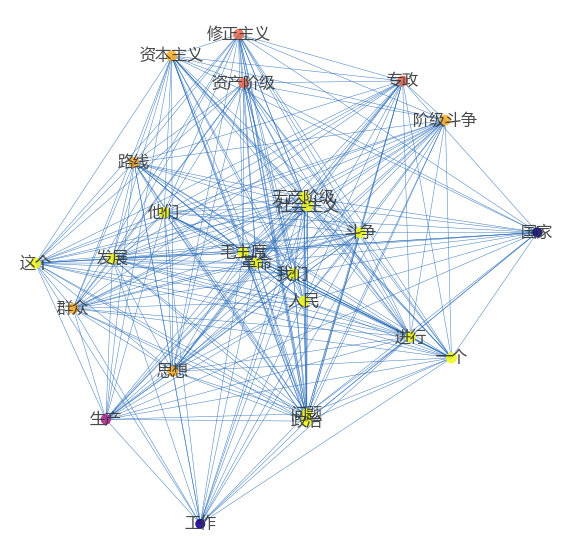

In [102]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered3065, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.eigenvector_centrality(giant_filtered3065)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered3065, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered3065.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered3065.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered3065.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [103]:
# 78-84

giant_filtered3075 = filterWords(giant75, minWeight=3, filter_='eigenvector', rule='number', value_of_rule=25)
print(nx.info(giant_filtered3075))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 141
Average degree:  11.2800


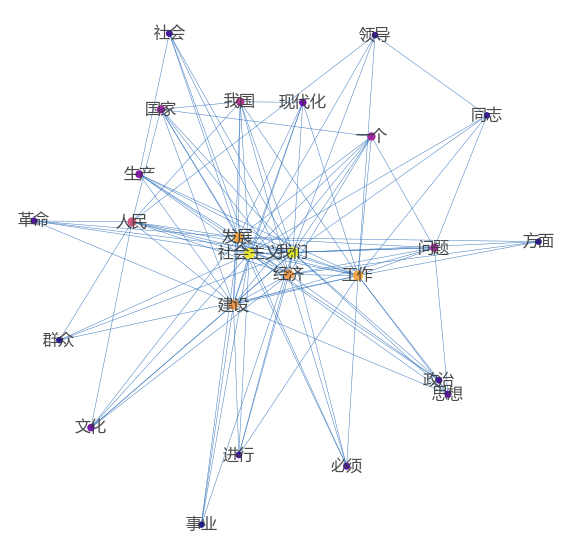

In [104]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered3075, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.eigenvector_centrality(giant_filtered3075)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered3075, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered3075.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered3075.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered3075.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [105]:
# 85-92

giant_filtered3085 = filterWords(giant85, minWeight=3, filter_='eigenvector', rule='number', value_of_rule=25)
print(nx.info(giant_filtered3085))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 94
Average degree:   7.5200


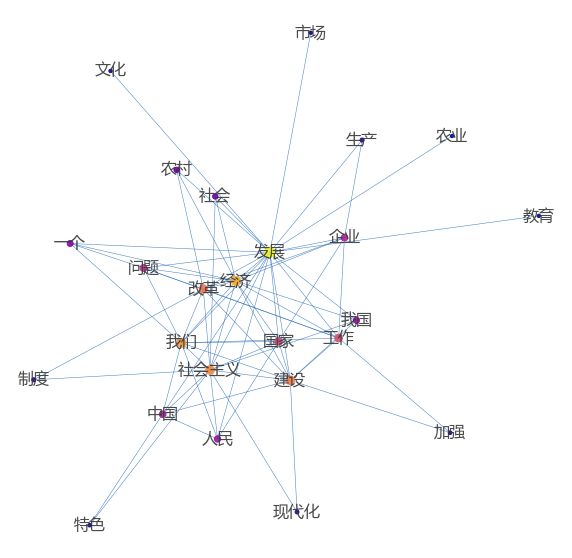

In [106]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered3085, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.eigenvector_centrality(giant_filtered3085)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered3085, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered3085.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered3085.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered3085.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [107]:
# 93-02

giant_filtered3095 = filterWords(giant95, minWeight=3, filter_='eigenvector', rule='number', value_of_rule=25)
print(nx.info(giant_filtered3095))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 164
Average degree:  13.1200


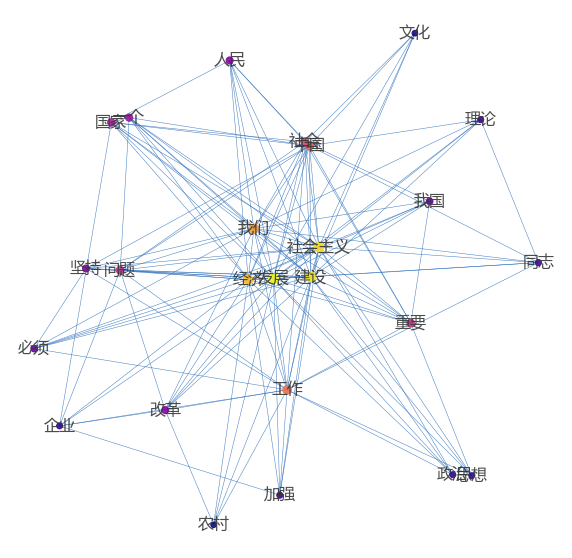

In [108]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered3095, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.eigenvector_centrality(giant_filtered3095)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered3095, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered3095.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered3095.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered3095.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [109]:
# stats

giant_list=[giant65,giant75,giant85,giant95]

giant_stat=[]

for inv in giant_list:
    temp=[]
    temp.append(nx.density(inv))
    temp.append(np.mean([v for w,v in nx.degree(inv)]))
    temp.append(nx.diameter(inv))
    giant_stat.append(temp)

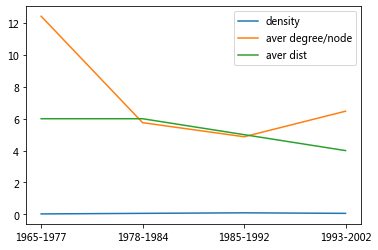

<Figure size 720x432 with 0 Axes>

In [110]:
ax=plt.gca()

plt.figure(figsize=(10,6))
ax.plot(['1965-1977','1978-1984','1985-1992','1993-2002'], [x[0] for x in giant_stat], label='density')
ax.plot(['1965-1977','1978-1984','1985-1992','1993-2002'], [x[1] for x in giant_stat], label='aver degree/node')
ax.plot(['1965-1977','1978-1984','1985-1992','1993-2002'], [x[2] for x in giant_stat], label='aver dist')
ax.legend()

In [111]:
# centrality score change over period

print(dcentralities65['经济'],dcentralities75['经济'],dcentralities85['经济'],dcentralities95['经济'])

0.053784860557768925 0.29166666666666663 0.2884615384615385 0.3211009174311927


In [113]:
%%time

# score change yearly

target_word_list=['经济','社会主义','发展','革命','无产阶级','资产阶级','资本主义']
cscore_dict_d={}
cscore_dict_e={}

for year in range(1965, 2003):
    print('running currently on {}'.format(year),end='\r',flush=True)
    g_loop = wordCooccurrence(corpus[corpus['year']==year]['tokenized_sent'].sum())
    g_loop.remove_nodes_from(list(nx.isolates(g_loop))) #since we are changing the graph list() evaluates the isolates first
    giant_loop = max(connected_component_subgraphs(g_loop), key=len) # keep just the giant connected component
    
    dcentralities_loop = nx.degree_centrality(giant_loop)
    #ecentralities_loop = nx.eigenvector_centrality(giant_loop)
    
    try:
        for word in target_word_list:
            
            if word not in cscore_dict_d.keys():
                cscore_dict_d[word]=[]
                cscore_dict_d[word].append(dcentralities_loop[word])
            else:
                cscore_dict_d[word].append(dcentralities_loop[word])
            
            #if word not in cscore_dict_e.keys():
            #    cscore_dict_e[word]=[]
            #    cscore_dict_e[word].append(ecentralities_loop[word])
            #else:
            #    cscore_dict_e[word].append(ecentralities_loop[word])
                
    except Exception:
        print('Word {} does not appear in year {}, try another one.'.format(word,year))
        break

CPU times: user 12min 38s, sys: 2min 19s, total: 14min 58s
Wall time: 15min 18s


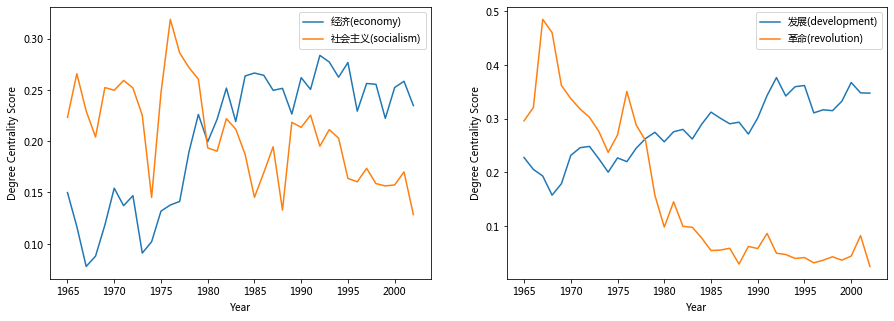

In [120]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(range(1965,2003),cscore_dict_d['经济'],label='经济(economy)')
ax1.plot(range(1965,2003),cscore_dict_d['社会主义'],label='社会主义(socialism)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Degree Centrality Score')
ax1.legend()

ax2.plot(range(1965,2003),cscore_dict_d['发展'],label='发展(development)')
ax2.plot(range(1965,2003),cscore_dict_d['革命'],label='革命(revolution)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Degree Centrality Score')
ax2.legend()

#ax3.plot(range(1965,2003),cscore_dict_d['发展'],label='development')
#ax3.plot(range(1965,2003),cscore_dict_d['革命'],label='revolution')
#ax3.set_xlabel('Year')
#ax3.set_ylabel('Degree Centrality Score')
#ax3.legend()

#ax4.plot(range(1965,2003),cscore_dict_e['经济'],label='economy')
#ax4.plot(range(1965,2003),cscore_dict_e['社会主义'],label='socialism')
#ax4.set_xlabel('Year')
#ax4.set_ylabel('Eigenvector Centrality Score')
#ax4.legend()

#ax5.plot(range(1965,2003),cscore_dict_e['发展'],label='development')
#ax5.plot(range(1965,2003),cscore_dict_e['革命'],label='fight/stuggle')
#ax5.set_xlabel('Year')
#ax5.set_ylabel('Eigenvector Centrality Score')
#ax5.legend()

#ax6.plot(range(1965,2003),cscore_dict_e['发展'],label='development')
#ax6.plot(range(1965,2003),cscore_dict_e['革命'],label='revolution')
#ax6.set_xlabel('Year')
#ax6.set_ylabel('Eigenvector Centrality Score')
#ax6.legend()

In [19]:
%%time

# all
# sampling, otherwise the server will shut down

g_all = wordCooccurrence(corpus['tokenized_sent'].sum()[::100])

CPU times: user 1min 54s, sys: 4.54 s, total: 1min 59s
Wall time: 1min 58s


In [23]:
%%time

gall_2=g_all.copy()

gall_2.remove_edges_from([(n1, n2) for n1, n2, d in gall_2.edges(data = True) if d['weight'] <= 20])
gall_2.remove_nodes_from(list(nx.isolates(gall_2))) #since we are changing the graph list() evaluates the isolates first
len(gall_2)

CPU times: user 1.97 s, sys: 26.6 ms, total: 1.99 s
Wall time: 1.99 s


259

In [26]:
giant_all = max(connected_component_subgraphs(gall_2), key=len) # keep just the giant connected component
print(nx.info(giant_all))

Name: 
Type: Graph
Number of nodes: 227
Number of edges: 851
Average degree:   7.4978


In [29]:
# all filter

giant_filtered30all = filterWords(giant_all, minWeight=3, filter_='degree', rule='number', value_of_rule=40)
print(nx.info(giant_filtered30all))

Total number of nodes(after filtering) in the graph is 40
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 362
Average degree:  18.1000


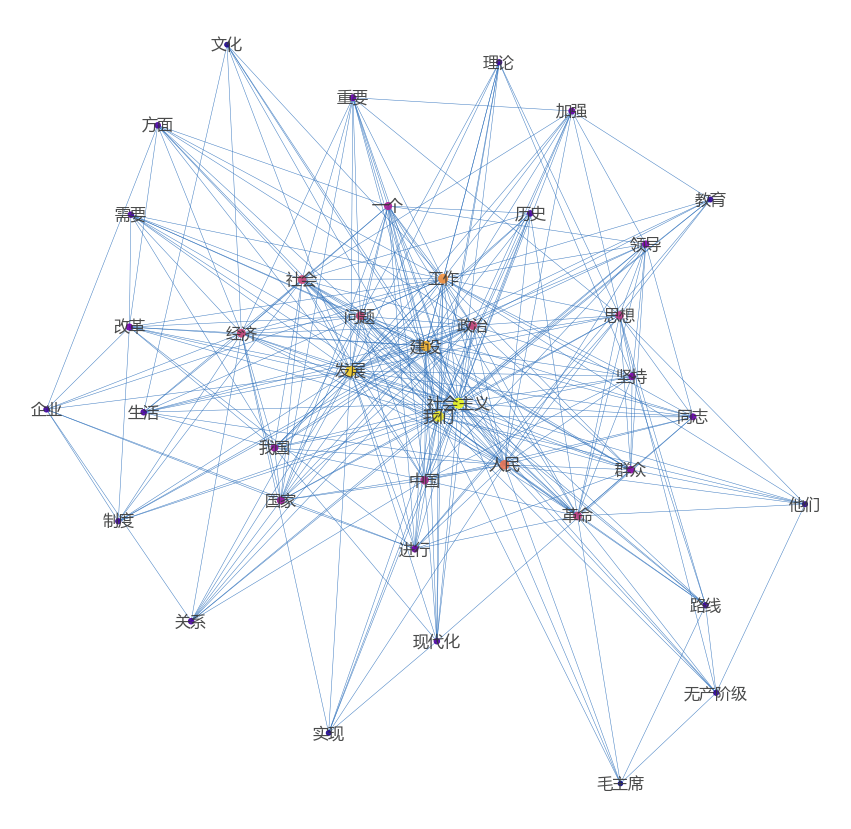

In [120]:
# chinese

layout_giant_filtered30 = nx.spring_layout(giant_filtered30all, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (15,15))
centralities_giant30 = nx.degree_centrality(giant_filtered30all)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30all, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30all.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30all.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30all.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [32]:
# translation

gall_dict={}

for n in giant_filtered30all.nodes():
    print(n,translator.translate(n,dest='en').text)
    gall_dict[n]=translator.translate(n,dest='en').text

现代化 modernization
经济 economic
教育 education
重要 important
进行 get on
发展 development of
思想 thought
文化 culture
工作 jobs
社会 society
企业 enterprise
坚持 adhere to
国家 country
生活 life
改革 reform
革命 revolution
路线 route
我们 we
关系 relationship
无产阶级 proletariat
实现 achieve
加强 strengthen
需要 need
毛主席 Chairman mao
政治 political
制度 system
一个 One
中国 China
他们 they
领导 leadership
理论 theory
方面 aspect
历史 history
社会主义 socialism
问题 problem
我国 Country
建设 Construction
群众 the masses
同志 Comrade
人民 people


In [33]:
# modify some translations

gall_dict['我国']='our country'
gall_dict['发展']='development'
gall_dict['毛主席']='Chairman Mao'

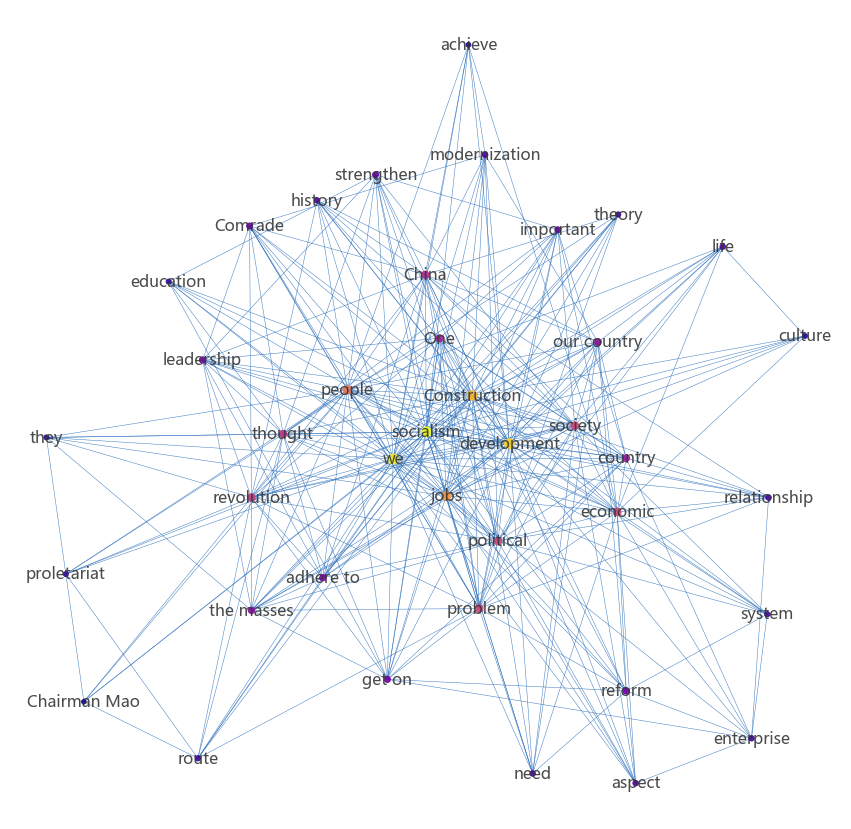

In [35]:
# english version


layout_giant_filtered30 = nx.spring_layout(giant_filtered30all, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (15,15))
centralities_giant30 = nx.degree_centrality(giant_filtered30all)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30all, ax = ax, pos = layout_giant_filtered30, labels = {n: gall_dict[n] for n in giant_filtered30all.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30all.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30all.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

### network of important person

In [119]:
# import hanlp package to extract the names in corpus

import hanlp
recognizer = hanlp.load(hanlp.pretrained.ner.MSRA_NER_BERT_BASE_ZH)

Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LookupTableImportV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/t

In [50]:
%%time
%%capture

# due to the limitation of pacakge, sampling will be used to run model
# warning comes from the limiation of pack itself. After the mannual check, the truncated part 
# of these lists almost has no influence on the name selection. 

vip_name={}
for i, para in enumerate(corpus['tokenized_sent'][::30]):
    print('running on {}'.format(i))
    for sent in para:
        strs=''.join(sent)
        if len(strs)>126:
            cut=len(sent)//2
            sent2=[sent[:cut],sent[cut:]]
        else:
            sent2=[sent]
        
        for sent_cut in sent2:
            try:
                rec=recognizer(sent_cut)
                
                for ele in rec:
                    if ele[1]=='NR':
                        temp=ele[0].split()
                        if temp[0] in vip_name.keys():
                            vip_name[temp[0]]+=1
                        else:
                            vip_name[temp[0]]=1
            except Exception:
                continue


20-06-06 16:19:38 WARNING Input tokens ['孙武', '孙膑', '卫青', '霍去病', '成吉思汗', '国度', '产生', '嬴政', '刘邦', '曹操', '诸葛亮', '李世民', '松赞干布', '朱元璋', '爱新觉罗', '玄烨', '国度', '产生', '岳飞', '文天祥', '戚继光', '郑成功', '林则徐', '国度', '产生', '陈胜吴广', '张角', '黄巢', '李自成', '洪秀全', '国度', '产生', '康有为', '严复', '谭嗣同', '孙中山', '章太炎', '国度', '产生', '李大钊', '瞿秋白', '毛泽东', '周恩来', '刘少奇', '朱德', '董必武', '彭德怀', '贺龙', '陈毅', '国度'] exceed the max sequence length of 126. The exceeded part will be truncated and ignored. You are recommended to split your long text into several sentences within 126 tokens beforehand.
20-06-06 16:43:35 WARNING Input tokens ['根据', '辽宁', '实际', '情况', '主要', '实现', '八个', '转变', '一是', '经济', '运行机制', '上要', '习惯于', '生产', '计划', '产品', '包销', '原材料', '统配', '花钱', '拨款', '充分运用', '市场机制', '优化', '生产', '要素', '配置', '上来', '建立', '市场', '搞活', '流通', '形成', '市场', '导向', '新机制', '二是', '经济', '发展', '路子', '上要', '投入', '产出', '大力', '小钱', '转到', '最终', '产品', '抓起', '提高', '经济效益', '中心', '发展', '精深', '加工', '提高', '产品', '技术含量', '附加值', '上来', '走低', '投入', '高产出', '积累', '经济', '

CPU times: user 4h 51min 30s, sys: 3h 12min 25s, total: 8h 3min 55s
Wall time: 1h 15min 37s


In [52]:
sorted(vip_name.items(), reverse = True, key = lambda x:x[1])[:10]

[('毛主席', 191),
 ('列宁', 71),
 ('刘少奇', 57),
 ('邓小平', 53),
 ('马克思主义', 52),
 ('马克思', 49),
 ('毛泽东', 45),
 ('同志', 42),
 ('李鹏', 40),
 ('江泽民', 38)]

In [54]:
# export the names and their freq

with open("vip_name_freq_network.txt", "w") as text_file:
    for name in sorted(vip_name.items(), reverse = True, key = lambda x:x[1]):
        text_file.write(str(name)+'\n')

In [59]:
# as the identification is not good enough, i mannually select the meaningful chinese names
# add some influential chinese economists that may be missed by hanlp.

vip_name_list=['毛主席','刘少奇','邓小平','毛泽东','李鹏','江泽民',
               '刘晓波','周恩来','宋健',
               '朱镕基','周总理','赵紫阳',
               '郭沫若','杜润生','王蒙','钱其琛',
               '华国锋','胡耀邦','小平','胡锦涛',
               '茅于轼','陈云','钱学森',
               '李岚清','江主席','厉以宁','江平',
               '吴敬琏','林毅夫','周其仁','刘鹤','樊纲','张维迎']


In [60]:
len(vip_name_list)

33

In [61]:
vip_network65 = nx.Graph()
vip_network75 = nx.Graph()
vip_network85 = nx.Graph()
vip_network95 = nx.Graph()

for name in vip_name_list:
    vip_network65.add_node(name, words=[])
    vip_network75.add_node(name, words=[])
    vip_network85.add_node(name, words=[])
    vip_network95.add_node(name, words=[])

In [62]:
# 1965-1977

for doc in corpus_65['tokenized_sent']:
    for sent in doc:
        for token in sent:
            if token in vip_network65.nodes():
                for sent_ in doc:
                    for token_ in sent_:
                    # if both the characters exist in the graph, add a weight
                        if token_ != token and token_ in vip_network65.nodes():
                            if (token, token_) not in vip_network65.edges():
                                vip_network65.add_edge(token, token_, weight=0)
                            if (token, token_) in vip_network65.edges():
                                vip_network65.edges[(token, token_)]['weight'] += 1

# as some people have different title in the news, i.e. Zedong Mao(毛泽东) and Chairman Mao (毛主席)，
# merge theses titles referring to the same person.

for name in vip_name_list:
    
    if ('毛主席',name) in vip_network65.edges():
        
        temp=vip_network65.edges[('毛主席', name)]['weight']
        vip_network65.remove_node('毛主席')
        
        if ('毛泽东',name) not in vip_network65.edges():
            vip_network65.add_edge('毛泽东', name, weight=temp)
        if ('毛泽东',name) in vip_network65.edges():
            vip_network65.edges[('毛泽东',name)]['weight'] += temp
    
    if ('小平',name) in vip_network65.edges():
        
        temp=vip_network65.edges[('小平', name)]['weight']
        vip_network65.remove_node('小平')
        
        if ('邓小平',name) not in vip_network65.edges():
            vip_network65.add_edge('邓小平', name, weight=temp)
        if ('邓小平',name) in vip_network65.edges():
            vip_network65.edges[('邓小平',name)]['weight'] += temp
    
    if ('江主席',name) in vip_network65.edges():
        
        temp=vip_network65.edges[('江主席', name)]['weight']
        vip_network65.remove_node('江主席')
        
        if ('江泽民',name) not in vip_network65.edges():
            vip_network65.add_edge('江泽民', name, weight=temp)
        if ('江泽民',name) in vip_network65.edges():
            vip_network65.edges[('江泽民',name)]['weight'] += temp
    
    if ('周总理',name) in vip_network65.edges():
        
        temp=vip_network65.edges[('周总理', name)]['weight']
        vip_network65.remove_node('周总理')
        
        if ('周恩来',name) not in vip_network65.edges():
            vip_network65.add_edge('周恩来', name, weight=temp)
        if ('周恩来',name) in vip_network65.edges():
            vip_network65.edges[('周恩来',name)]['weight'] += temp
            

In [63]:
vip_network65.remove_nodes_from(list(nx.isolates(vip_network65)))

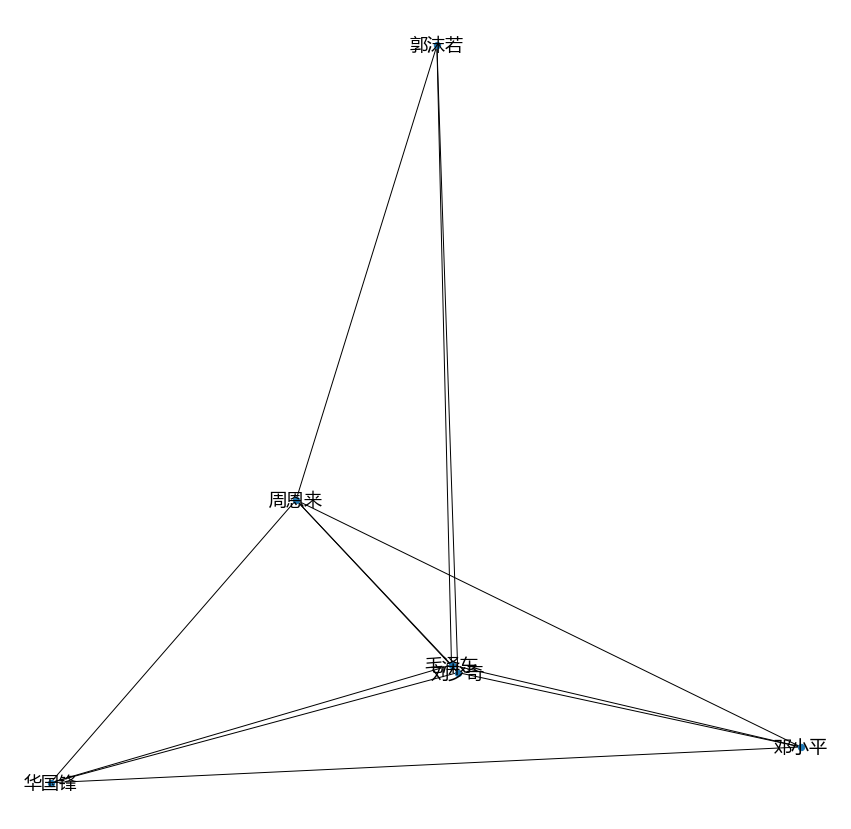

In [64]:
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(vip_network65, ax = ax, with_labels=True, node_size = 40, font_size=18)

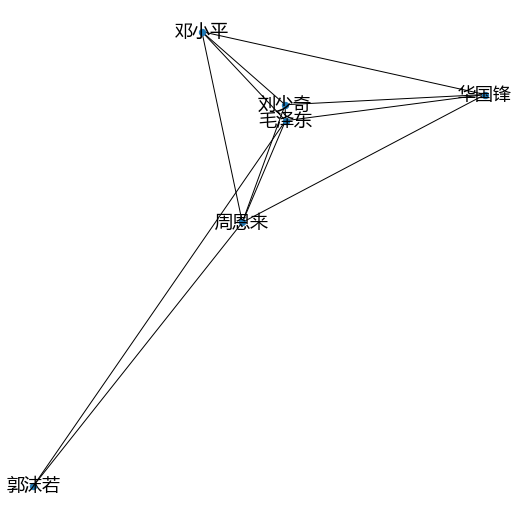

In [65]:
smallvip_network65 = nx.Graph()

for chair1 in vip_network65.nodes():
    smallvip_network65.add_node(chair1, words=vip_network65.nodes[chair1]['words'])
    for chair2 in vip_network65.nodes():
        if (chair1, chair2) in vip_network65.edges() and chair1!=chair2 and vip_network65.edges[(chair1, chair2)]['weight'] >= 50:
            smallvip_network65.add_edge(chair1, chair2, weight=vip_network65.edges[(chair1, chair2)]['weight'])

smallvip_network65.remove_nodes_from(list(nx.isolates(smallvip_network65)))

plt.figure(figsize=(7,7))
nx.draw(smallvip_network65, with_labels=True,node_size = 40, font_size=18)

In [66]:
# 1978-1984

for doc in corpus_75['tokenized_sent']:
    for sent in doc:
        for token in sent:
            if token in vip_network75.nodes():
                for sent_ in doc:
                    for token_ in sent_:
                    # if both the characters exist in the graph, add a weight
                        if token_ != token and token_ in vip_network75.nodes():
                            if (token, token_) not in vip_network75.edges():
                                vip_network75.add_edge(token, token_, weight=0)
                            if (token, token_) in vip_network75.edges():
                                vip_network75.edges[(token, token_)]['weight'] += 1
                                
for name in vip_name_list:
    
    if ('毛主席',name) in vip_network75.edges():
        
        temp=vip_network75.edges[('毛主席', name)]['weight']
        vip_network75.remove_node('毛主席')
        
        if ('毛泽东',name) not in vip_network75.edges():
            vip_network75.add_edge('毛泽东', name, weight=temp)
        if ('毛泽东',name) in vip_network75.edges():
            vip_network75.edges[('毛泽东',name)]['weight'] += temp
    
    if ('小平',name) in vip_network75.edges():
        
        temp=vip_network75.edges[('小平', name)]['weight']
        vip_network75.remove_node('小平')
        
        if ('邓小平',name) not in vip_network75.edges():
            vip_network75.add_edge('邓小平', name, weight=temp)
        if ('邓小平',name) in vip_network75.edges():
            vip_network75.edges[('邓小平',name)]['weight'] += temp
    
    if ('江主席',name) in vip_network75.edges():
        
        temp=vip_network75.edges[('江主席', name)]['weight']
        vip_network75.remove_node('江主席')
        
        if ('江泽民',name) not in vip_network75.edges():
            vip_network75.add_edge('江泽民', name, weight=temp)
        if ('江泽民',name) in vip_network75.edges():
            vip_network75.edges[('江泽民',name)]['weight'] += temp
    
    if ('周总理',name) in vip_network75.edges():
        
        temp=vip_network75.edges[('周总理', name)]['weight']
        vip_network75.remove_node('周总理')
        
        if ('周恩来',name) not in vip_network75.edges():
            vip_network75.add_edge('周恩来', name, weight=temp)
        if ('周恩来',name) in vip_network75.edges():
            vip_network75.edges[('周恩来',name)]['weight'] += temp
            

In [68]:
vip_network75.remove_nodes_from(list(nx.isolates(vip_network75)))

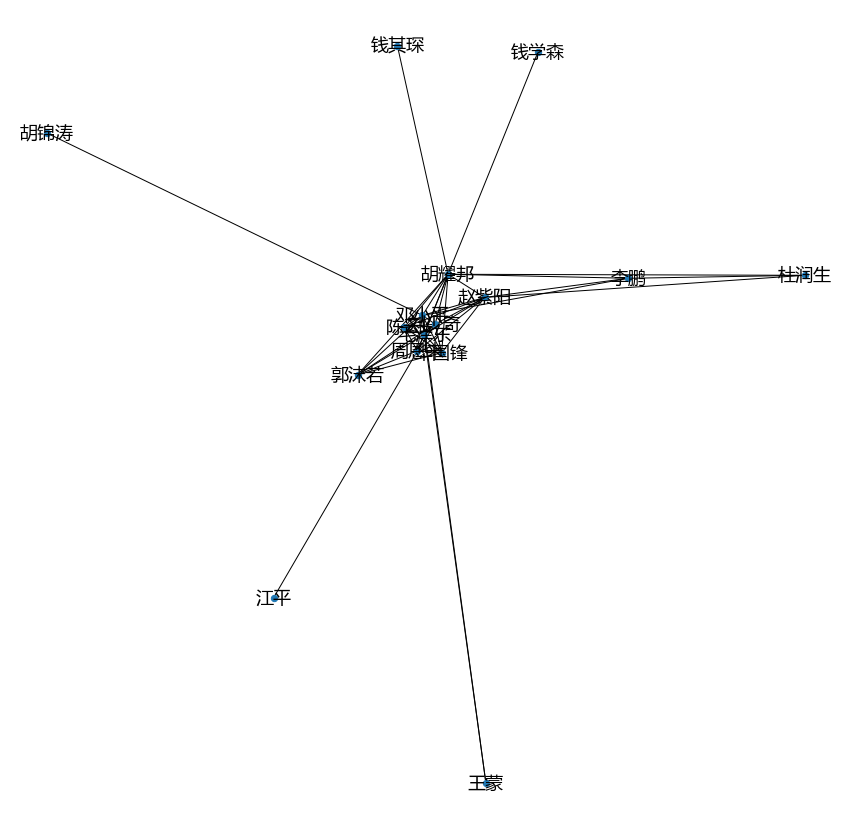

In [69]:
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(vip_network75, ax = ax, with_labels=True,node_size = 40, font_size=18)

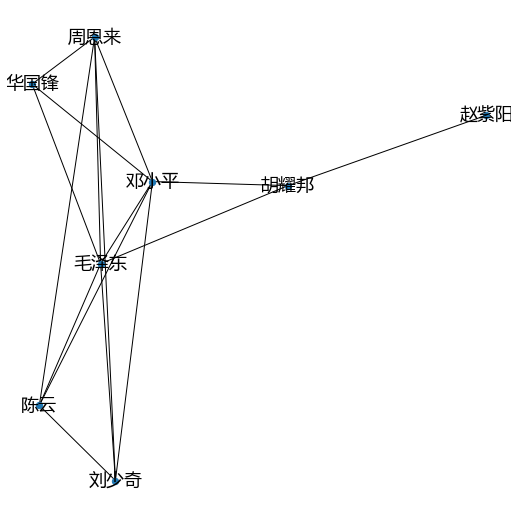

In [70]:
smallvip_network75 = nx.Graph()

for chair1 in vip_network75.nodes():
    smallvip_network75.add_node(chair1, words=vip_network75.nodes[chair1]['words'])
    for chair2 in vip_network75.nodes():
        if (chair1, chair2) in vip_network75.edges() and chair1!=chair2 and vip_network75.edges[(chair1, chair2)]['weight'] >= 350:
            smallvip_network75.add_edge(chair1, chair2, weight=vip_network75.edges[(chair1, chair2)]['weight'])

smallvip_network75.remove_nodes_from(list(nx.isolates(smallvip_network75)))

plt.figure(figsize=(7,7))
nx.draw(smallvip_network75, with_labels=True,node_size = 40, font_size=18)

In [71]:
# 1985-1992

for doc in corpus_85['tokenized_sent']:
    for sent in doc:
        for token in sent:
            if token in vip_network85.nodes():
                for sent_ in doc:
                    for token_ in sent_:
                    # if both the characters exist in the graph, add a weight
                        if token_ != token and token_ in vip_network85.nodes():
                            if (token, token_) not in vip_network85.edges():
                                vip_network85.add_edge(token, token_, weight=0)
                            if (token, token_) in vip_network85.edges():
                                vip_network85.edges[(token, token_)]['weight'] += 1
                                
for name in vip_name_list:
    
    if ('毛主席',name) in vip_network85.edges():
        
        temp=vip_network85.edges[('毛主席', name)]['weight']
        vip_network85.remove_node('毛主席')
        
        if ('毛泽东',name) not in vip_network85.edges():
            vip_network85.add_edge('毛泽东', name, weight=temp)
        if ('毛泽东',name) in vip_network85.edges():
            vip_network85.edges[('毛泽东',name)]['weight'] += temp
    
    if ('小平',name) in vip_network85.edges():
        
        temp=vip_network85.edges[('小平', name)]['weight']
        vip_network85.remove_node('小平')
        
        if ('邓小平',name) not in vip_network85.edges():
            vip_network85.add_edge('邓小平', name, weight=temp)
        if ('邓小平',name) in vip_network85.edges():
            vip_network85.edges[('邓小平',name)]['weight'] += temp
    
    if ('江主席',name) in vip_network85.edges():
        
        temp=vip_network85.edges[('江主席', name)]['weight']
        vip_network85.remove_node('江主席')
        
        if ('江泽民',name) not in vip_network85.edges():
            vip_network85.add_edge('江泽民', name, weight=temp)
        if ('江泽民',name) in vip_network85.edges():
            vip_network85.edges[('江泽民',name)]['weight'] += temp
    
    if ('周总理',name) in vip_network85.edges():
        
        temp=vip_network85.edges[('周总理', name)]['weight']
        vip_network85.remove_node('周总理')
        
        if ('周恩来',name) not in vip_network85.edges():
            vip_network85.add_edge('周恩来', name, weight=temp)
        if ('周恩来',name) in vip_network85.edges():
            vip_network85.edges[('周恩来',name)]['weight'] += temp
            

In [72]:
vip_network85.remove_nodes_from(list(nx.isolates(vip_network85)))

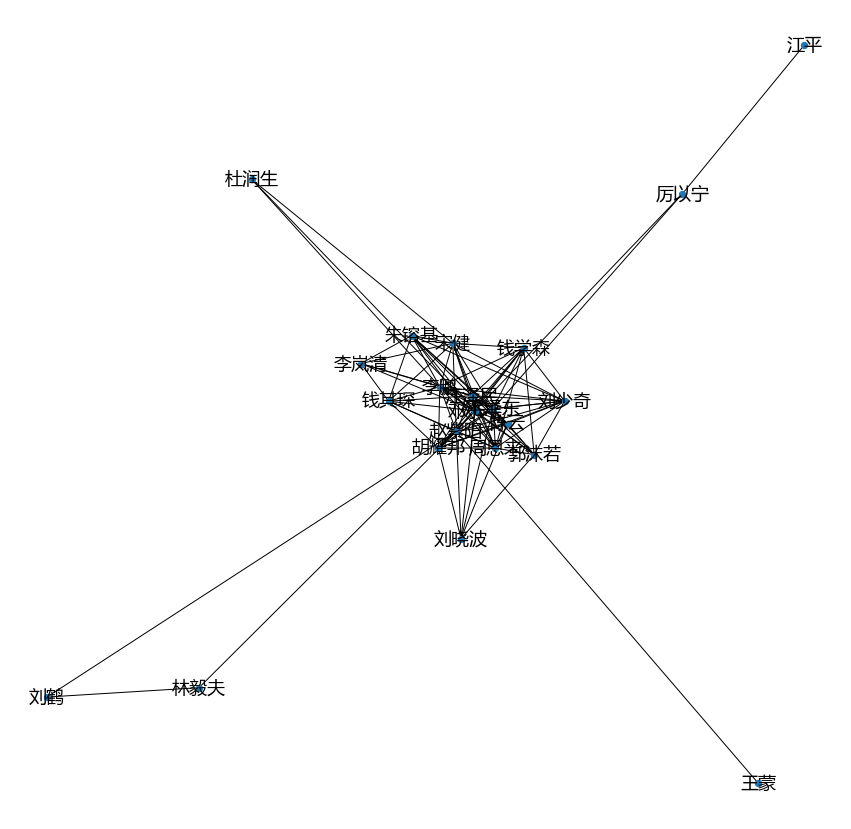

In [73]:
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(vip_network85, ax = ax, with_labels=True,node_size = 40, font_size=18)

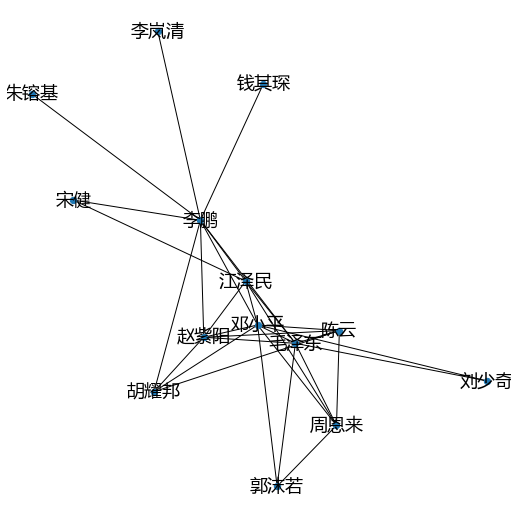

In [74]:
smallvip_network85 = nx.Graph()

for chair1 in vip_network85.nodes():
    smallvip_network85.add_node(chair1, words=vip_network85.nodes[chair1]['words'])
    for chair2 in vip_network85.nodes():
        if (chair1, chair2) in vip_network85.edges() and chair1!=chair2 and vip_network85.edges[(chair1, chair2)]['weight'] >= 50:
            smallvip_network85.add_edge(chair1, chair2, weight=vip_network85.edges[(chair1, chair2)]['weight'])

smallvip_network85.remove_nodes_from(list(nx.isolates(smallvip_network85)))

plt.figure(figsize=(7,7))
nx.draw(smallvip_network85, with_labels=True,node_size = 40, font_size=18)

In [75]:
# 1993-2002

for doc in corpus_95['tokenized_sent']:
    for sent in doc:
        for token in sent:
            if token in vip_network95.nodes():
                for sent_ in doc:
                    for token_ in sent_:
                    # if both the characters exist in the graph, add a weight
                        if token_ != token and token_ in vip_network95.nodes():
                            if (token, token_) not in vip_network95.edges():
                                vip_network95.add_edge(token, token_, weight=0)
                            if (token, token_) in vip_network95.edges():
                                vip_network95.edges[(token, token_)]['weight'] += 1
                                
                                
                                
for name in vip_name_list:
    
    if ('毛主席',name) in vip_network95.edges():
        
        temp=vip_network95.edges[('毛主席', name)]['weight']
        vip_network95.remove_node('毛主席')
        
        if ('毛泽东',name) not in vip_network95.edges():
            vip_network95.add_edge('毛泽东', name, weight=temp)
        if ('毛泽东',name) in vip_network95.edges():
            vip_network95.edges[('毛泽东',name)]['weight'] += temp
    
    if ('小平',name) in vip_network95.edges():
        
        temp=vip_network95.edges[('小平', name)]['weight']
        vip_network95.remove_node('小平')
        
        if ('邓小平',name) not in vip_network95.edges():
            vip_network95.add_edge('邓小平', name, weight=temp)
        if ('邓小平',name) in vip_network95.edges():
            vip_network95.edges[('邓小平',name)]['weight'] += temp
    
    if ('江主席',name) in vip_network95.edges():
        
        temp=vip_network95.edges[('江主席', name)]['weight']
        vip_network95.remove_node('江主席')
        
        if ('江泽民',name) not in vip_network95.edges():
            vip_network95.add_edge('江泽民', name, weight=temp)
        if ('江泽民',name) in vip_network95.edges():
            vip_network95.edges[('江泽民',name)]['weight'] += temp
    
    if ('周总理',name) in vip_network95.edges():
        
        temp=vip_network95.edges[('周总理', name)]['weight']
        vip_network95.remove_node('周总理')
        
        if ('周恩来',name) not in vip_network95.edges():
            vip_network95.add_edge('周恩来', name, weight=temp)
        if ('周恩来',name) in vip_network95.edges():
            vip_network95.edges[('周恩来',name)]['weight'] += temp

In [76]:
vip_network95.remove_nodes_from(list(nx.isolates(vip_network95)))

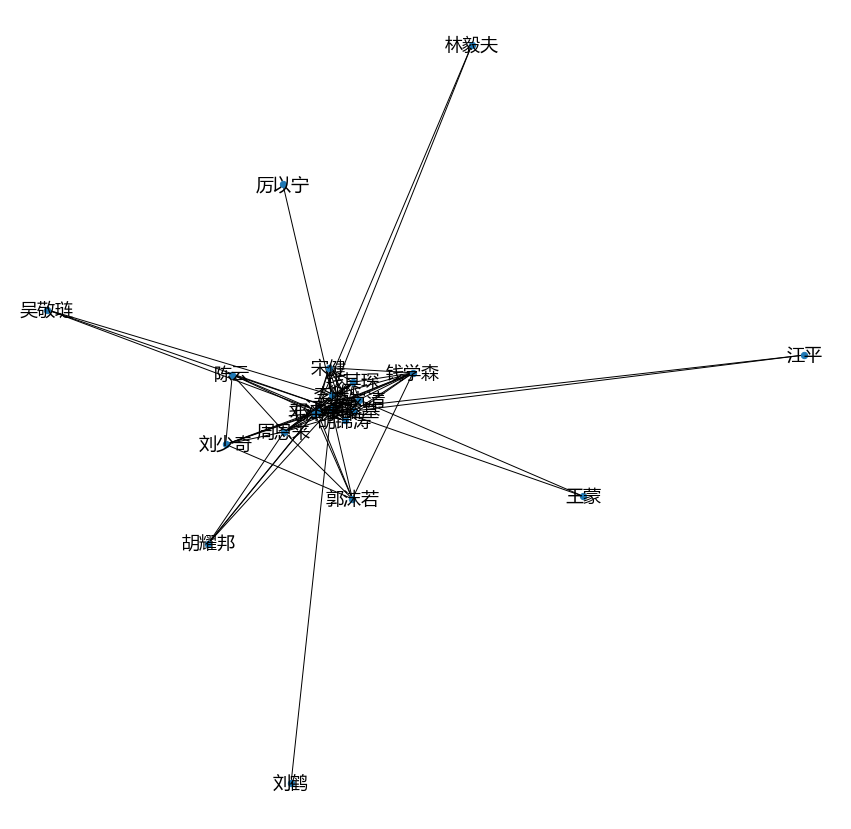

In [77]:
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(vip_network95, ax = ax, with_labels=True,node_size = 40, font_size=18)

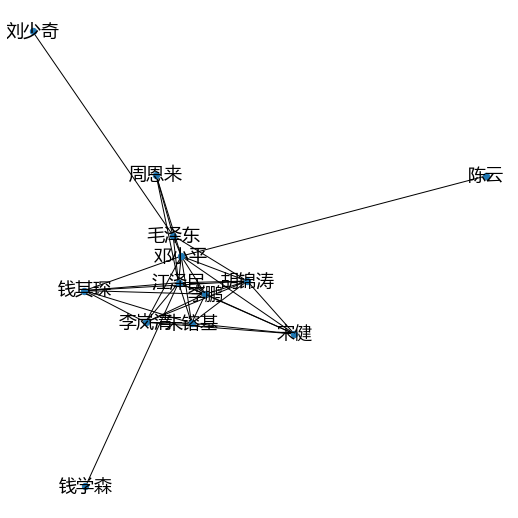

In [78]:
smallvip_network95 = nx.Graph()

for chair1 in vip_network95.nodes():
    smallvip_network95.add_node(chair1, words=vip_network95.nodes[chair1]['words'])
    for chair2 in vip_network95.nodes():
        if (chair1, chair2) in vip_network95.edges() and chair1!=chair2 and vip_network95.edges[(chair1, chair2)]['weight'] >= 100:
            smallvip_network95.add_edge(chair1, chair2, weight=vip_network95.edges[(chair1, chair2)]['weight'])

smallvip_network95.remove_nodes_from(list(nx.isolates(smallvip_network95)))

plt.figure(figsize=(7,7))
nx.draw(smallvip_network95, with_labels=True,node_size = 40, font_size=18)

In [38]:
# for all

vip_network_all = nx.Graph()

for name in vip_name_list:
    vip_network_all.add_node(name, words=[])

for doc in corpus['tokenized_sent']:
    for sent in doc:
        for token in sent:
            if token in vip_network_all.nodes():
                for sent_ in doc:
                    for token_ in sent_:
                    # if both the characters exist in the graph, add a weight
                        if token_ != token and token_ in vip_network_all.nodes():
                            if (token, token_) not in vip_network_all.edges():
                                vip_network_all.add_edge(token, token_, weight=0)
                            if (token, token_) in vip_network_all.edges():
                                vip_network_all.edges[(token, token_)]['weight'] += 1
                                
for name in vip_name_list:
    
    if ('毛主席',name) in vip_network_all.edges():
        
        temp=vip_network_all.edges[('毛主席', name)]['weight']
        vip_network_all.remove_node('毛主席')
        
        if ('毛泽东',name) not in vip_network_all.edges():
            vip_network_all.add_edge('毛泽东', name, weight=temp)
        if ('毛泽东',name) in vip_network_all.edges():
            vip_network_all.edges[('毛泽东',name)]['weight'] += temp
    
    if ('小平',name) in vip_network_all.edges():
        
        temp=vip_network_all.edges[('小平', name)]['weight']
        vip_network_all.remove_node('小平')
        
        if ('邓小平',name) not in vip_network_all.edges():
            vip_network_all.add_edge('邓小平', name, weight=temp)
        if ('邓小平',name) in vip_network_all.edges():
            vip_network_all.edges[('邓小平',name)]['weight'] += temp
    
    if ('江主席',name) in vip_network_all.edges():
        
        temp=vip_network_all.edges[('江主席', name)]['weight']
        vip_network_all.remove_node('江主席')
        
        if ('江泽民',name) not in vip_network_all.edges():
            vip_network_all.add_edge('江泽民', name, weight=temp)
        if ('江泽民',name) in vip_network_all.edges():
            vip_network_all.edges[('江泽民',name)]['weight'] += temp
    
    if ('周总理',name) in vip_network_all.edges():
        
        temp=vip_network_all.edges[('周总理', name)]['weight']
        vip_network_all.remove_node('周总理')
        
        if ('周恩来',name) not in vip_network_all.edges():
            vip_network_all.add_edge('周恩来', name, weight=temp)
        if ('周恩来',name) in vip_network_all.edges():
            vip_network_all.edges[('周恩来',name)]['weight'] += temp
        

In [39]:
vip_network_all.remove_nodes_from(list(nx.isolates(vip_network_all)))

In [43]:
# translation

vipall_dict={}

for n in vip_network_all.nodes():
    print(n,translator.translate(n,dest='en').text)
    vipall_dict[n]=translator.translate(n,dest='en').text

刘少奇 Liu Shaoqi
邓小平 Deng Xiaoping
毛泽东 Mao Zedong
李鹏 Li Peng
江泽民 Jiang Zemin
刘晓波 Liu Xiaobo
周恩来 Zhou Enlai
宋健 Song Jian
朱镕基 Zhu Rongji
赵紫阳 Zhao Ziyang
郭沫若 Guo
杜润生 Du Runsheng
王蒙 Wang Meng
钱其琛 Qian Qichen
华国锋 Hua Guofeng
胡耀邦 Hu Yaobang
胡锦涛 Hu Jintao
陈云 Chen Yun
钱学森 Qian
李岚清 Li Lanqing
厉以宁 Li Yining
江平 Jiang Ping
吴敬琏 Wu Jinglian
林毅夫 Lin Yifu
刘鹤 Liu He


In [44]:
# modify some trans

vipall_dict['郭沫若']='Guo Moruo'
vipall_dict['钱学森']='Qian Xuesen'

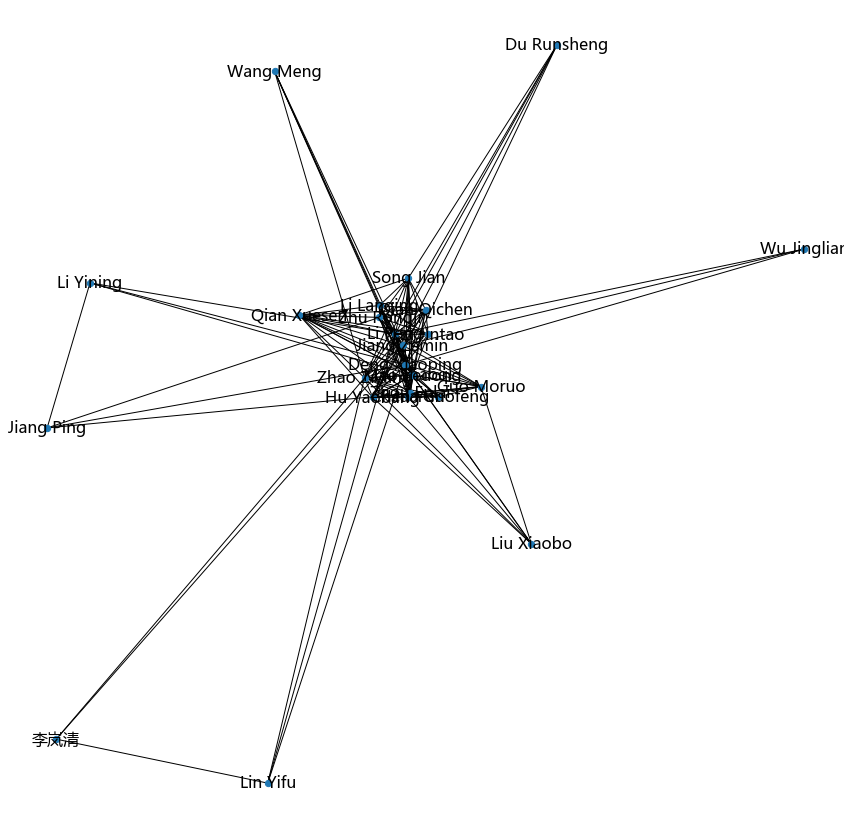

In [58]:
# english

fig, ax = plt.subplots(figsize = (15,15))
nx.draw(vip_network_all, ax = ax, with_labels=True,node_size = 40, font_size=16,labels = {n: vipall_dict[n] for n in vip_network_all.nodes()})

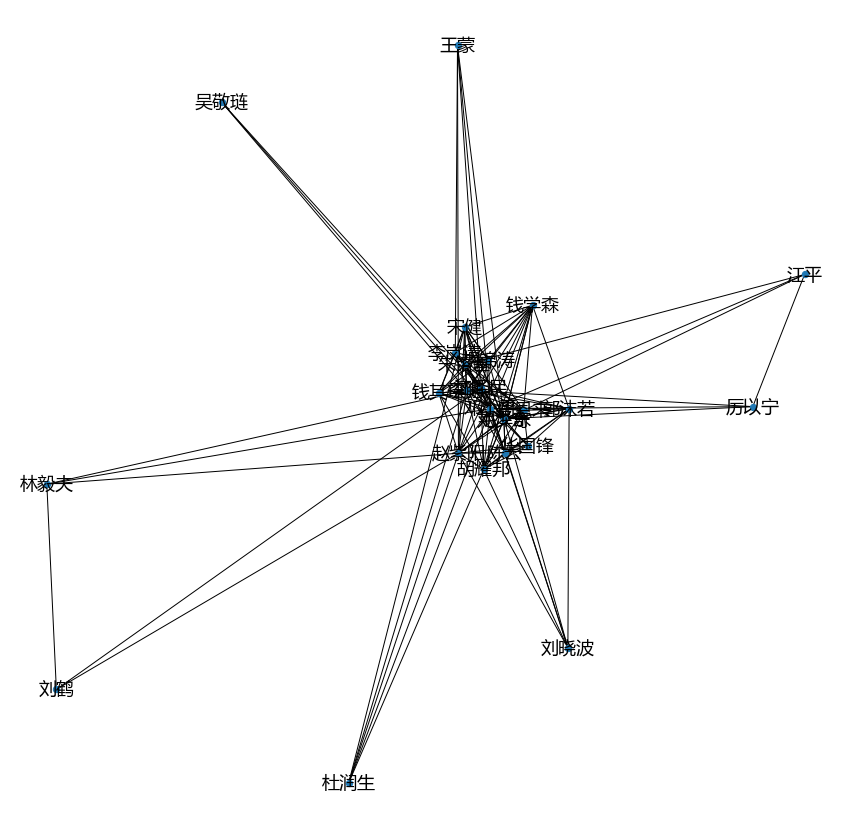

In [57]:
# chinese

fig, ax = plt.subplots(figsize = (15,15))
nx.draw(vip_network_all, ax = ax, with_labels=True,node_size = 40, font_size=18,labels = {n: n for n in vip_network_all.nodes()})

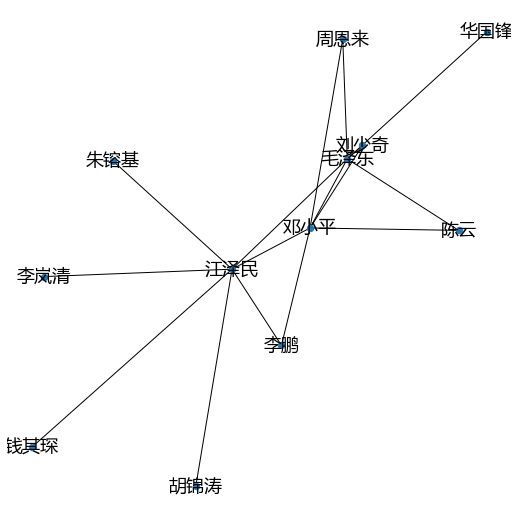

In [56]:
smallvip_network_all = nx.Graph()

for chair1 in vip_network_all.nodes():
    smallvip_network_all.add_node(chair1, words=vip_network_all.nodes[chair1]['words'])
    for chair2 in vip_network_all.nodes():
        if (chair1, chair2) in vip_network_all.edges() and chair1!=chair2 and vip_network_all.edges[(chair1, chair2)]['weight'] >= 1500:
            smallvip_network_all.add_edge(chair1, chair2, weight=vip_network_all.edges[(chair1, chair2)]['weight'])

smallvip_network_all.remove_nodes_from(list(nx.isolates(smallvip_network_all)))

plt.figure(figsize=(7,7))
nx.draw(smallvip_network_all, with_labels=True,node_size = 40, font_size=18)

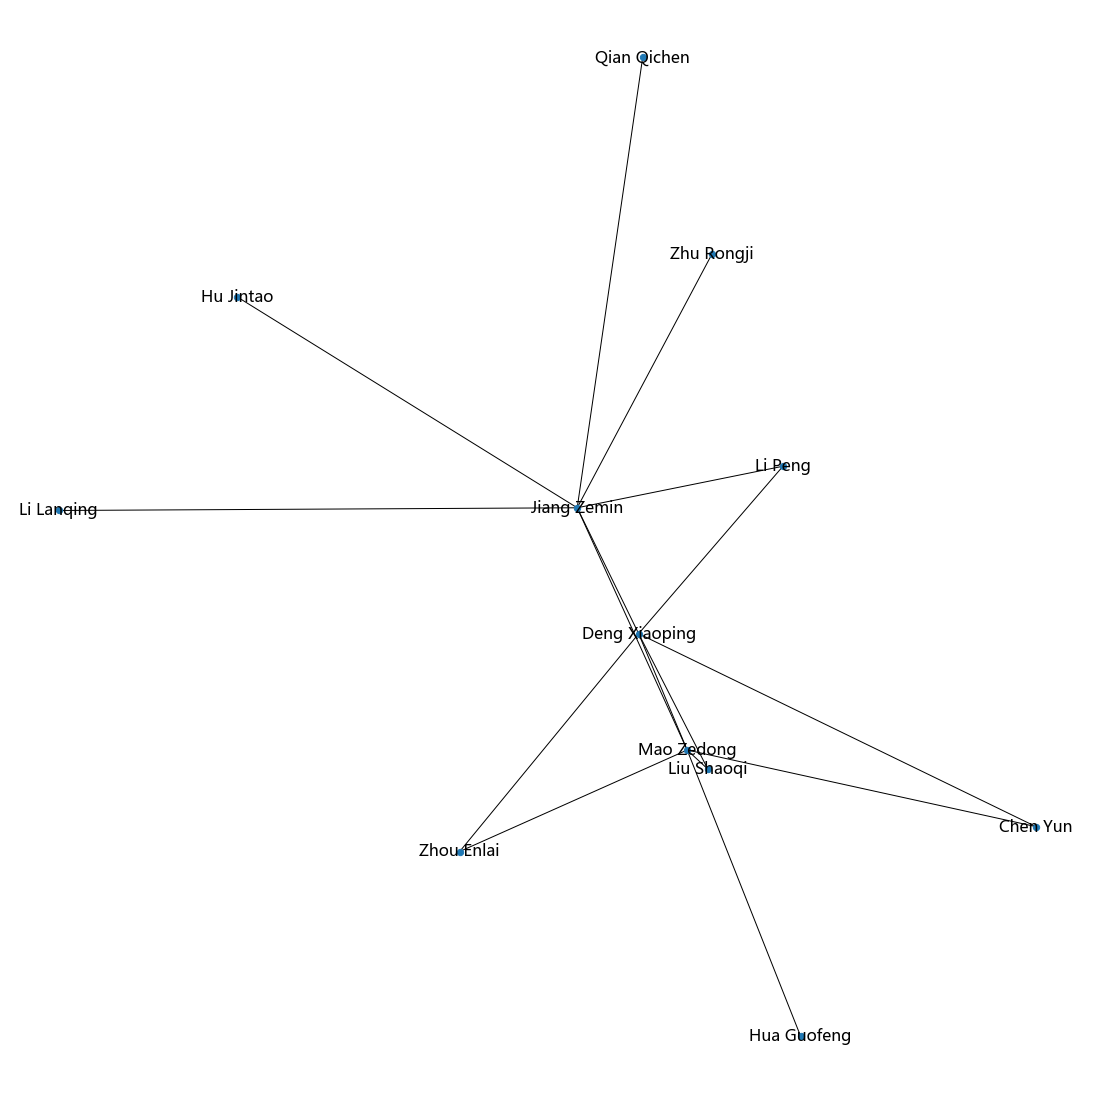

In [55]:
plt.figure(figsize=(15,15))
nx.draw(smallvip_network_all, with_labels=True,node_size = 40, font_size=16,labels = {n: vipall_dict[n] for n in smallvip_network_all.nodes()})